In [3]:
!pip install torchsummary

In [4]:
import numpy as np

import scipy.io
import os
from numpy.linalg import norm,det,inv,svd
from scipy.linalg import rq
import math
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage,spatial
from tqdm.notebook import trange,tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets,models,transforms
from  torch.utils.data import Dataset,DataLoader,ConcatDataset
from skimage import io,transform,data
from torchvision import transforms,utils
import  os
import sklearn.svm
import cv2
from os.path import exists
import pandas as pd
import PIL
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm,tqdm_notebook
from functools import partial
from  torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
class Image:
    def __init__(self,img,position):
        self.img = img
        self.position  = position
        
inliner_matchset = []
def features_matching(a,keypointlength,threshold):
    bestmatch = np.empty((keypointlength), dtype=np.int16)
    img1index = np.empty((keypointlength),dtype=np.init16)
    distance = np.empty((keypointlength))
    index =0
    for j in range(0,keypointlength):
        x=a[j]
        listx = x.tolist()
        x.sort()
        minval1=x[0]
        minval2=x[1]
        itemindex1 = listx.index(minval1)
        itemindex2 = listx.index(minval2)
        ratio = minval1/minval2
            
        if ratio < threshold:
            bestmatch[index] = itemindex1
            distance[index] = minval1
            img1index[index] = j
            index = index + 1
    return [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
    
def compute_Hmography(im1_pts,im2_pts):
    num_matches=len(im1_pts)
    num_rows = 2*num_matches
    num_cols = 9
    A_matrix_shape = (num_rows,num_cols)
    A = np.zeros(A_matrix_shape)
    a_index = 0
    for i in range(0,num_matches):
        (a_x,a_y) = im1_pts[i]
        (b_x,b_y) = im2_pts[i]
        row1 = [a_x,a_y,1,0,0,0,-b_x*a_x,-b_x*a_y,-b_x]
        row2 = [0,0,0,a_x,a_y,1,-b_y*a_x,-b_y*a_y,-b_y]
        A[a_index] = row1
    
        A[a_index+1] = row2
        a_index += 2
            
    U,s,Vt = np.linalg.svd(A)
    H = np.eye(3)
    H = Vt[-1].reshape(3,3)
    return H
    
def displayplot(img,title):
    plt.figure(figsize=(15,15))
    plt.title(title)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()
        
def RANSAC_alg(f1,f2,matches,nRANSAC,RANSACthresh):
    minMatches = 4
    nBest = 0
    best_inliners = []
    H_estimate = np.eye(3,3)
    global inliner_matchset
    inliner_matchset = []
    for iteration in range(nRANSAC):
        matchSimple = random.sample(matches,minMatches)
        im1_pts = np.empty((minMatches,2))
        im2_pts = np.empty((minMatches,2))
        for i in range(0,minMatches):
            m  = matchSimple[i]
            im1_pts[i] = f1[m.queryIdx].pt
            im2_pts[i] = f2[m.trainIdx].pt
                
        H_estimate = compute_Hmography(im1_pts,im2_pts)
        inliners = get_inliners(f1,f2,matches,H_estimate,RANSACthresh)
        if len(inliners) > nBest:
            nBest = len(inliners)
            best_inliners= inliners
                
    print("Number of best inliners", len(best_inliners))
    for i in range(len(best_inliners)):
        inliner_matchset.append(matches[best_inliners[i]])
    im1_pts = np.empty((len(best_inliners),2))
    im2_pts = np.empty((len(best_inliners),2))
    for i in range(0,len(best_inliners)):
        m = inliner_matchset[i]
        im1_pts[i] = f1[m.queryIdx].pt
        im2_pts[i] = f2[m.trainIdx].pt
    M = compute_Hmography(im1_pts,im2_pts)
    return M, len(best_inliners)
    

    

In [1]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 17.5 MB/s eta 0:00:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.1.48
    Uninstalling opencv-python-4.5.1.48:
      Successfully uninstalled opencv-python-4.5.1.48
     |████████████████████████████████| 30.6 MB 25.9 MB/s eta 0:00:01


In [2]:
import cv2
cv= cv2.xfeatures2d.SIFT_create()

In [6]:
files_all = os.listdir('../input/uni-campus-dataset/RGB-img/img/')
files_all.sort()

folder_path = '../input/uni-campus-dataset/RGB-img/img/'
left_files_path_rev = []
right_files_path = []
for file in files_all[:61]:
    left_files_path_rev.append(folder_path + file)
    
    
left_files_path = left_files_path_rev[::-1]


for file in files_all[61:100]:
    right_files_path.append(folder_path + file)

In [7]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
images_left_bgr = []
images_right_bgr = []
images_left = []
images_right = []


for file in tqdm(left_files_path):
    left_image_sat= cv2.imread(file)
    lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
    lab[...,0] = clahe.apply(lab[...,0])
    left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
    images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
    images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
    right_image_sat= cv2.imread(file)
    lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
    lab[...,0] = clahe.apply(lab[...,0])
    right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
    images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
    images_right_bgr.append(right_img)


100%|██████████| 39/39 [00:41<00:00,  1.07s/it]


In [8]:
images_left_bgr_no_enhance = []
images_right_bgr_no_enhance = []

for file in tqdm(left_files_path):
    left_image_sat= cv2.imread(file)
    left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
    images_left_bgr_no_enhance.append(left_img)

for file in tqdm(right_files_path):
    right_image_sat= cv2.imread(file)
    right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
    images_right_bgr_no_enhance.append(right_img)

100%|██████████| 39/39 [00:16<00:00,  2.43it/s]


In [ ]:
Threshl=60;
Octaves=8;
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]


keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]


for imgs in tqdm(images_left_bgr):
    kpt = brisk.detect(imgs,None)
    kpt,descrip = brisk.compute(imgs, kpt)
    keypoints_all_left_brisk.append(kpt)
    descriptors_all_left_brisk.append(descrip)
    points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
    kpt = brisk.detect(imgs,None)
    kpt,descrip = brisk.compute(imgs, kpt)
    keypoints_all_right_brisk.append(kpt)
    descriptors_all_right_brisk.append(descrip)
    points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

In [ ]:
orb = cv2.ORB_create(5000)
keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for imgs in tqdm(images_left_bgr):
    kpt = orb.detect(imgs,None)
    kpt,descrip = orb.compute(imgs, kpt)
    keypoints_all_left_orb.append(kpt)
    descriptors_all_left_orb.append(descrip)
    points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
    kpt = orb.detect(imgs,None)
    kpt,descrip = orb.compute(imgs, kpt)
    keypoints_all_right_orb.append(kpt)
    descriptors_all_right_orb.append(descrip)
    points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

In [27]:
kaze = cv2.KAZE_create()
keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for imgs in tqdm(images_left_bgr):
    kpt = kaze.detect(imgs,None)
    kpt,descrip = kaze.compute(imgs, kpt)
    keypoints_all_left_kaze.append(kpt)
    descriptors_all_left_kaze.append(descrip)
    points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
    kpt = kaze.detect(imgs,None)
    kpt,descrip = kaze.compute(imgs, kpt)
    keypoints_all_right_kaze.append(kpt)
    descriptors_all_right_kaze.append(descrip)
    points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 39/39 [04:41<00:00,  7.21s/it]


In [28]:
tqdm = partial(tqdm, position=0, leave=True)

In [10]:
akaze = cv2.AKAZE_create()
keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for imgs in tqdm(images_left_bgr):
    kpt = akaze.detect(imgs,None)
    kpt,descrip = akaze.compute(imgs, kpt)
    keypoints_all_left_akaze.append(kpt)
    descriptors_all_left_akaze.append(descrip)
    points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
for imgs in tqdm(images_right_bgr):
    kpt = akaze.detect(imgs,None)
    kpt,descrip = akaze.compute(imgs, kpt)
    keypoints_all_right_akaze.append(kpt)
    descriptors_all_right_akaze.append(descrip)
    points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 39/39 [00:52<00:00,  1.34s/it]


In [ ]:
star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]


keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for imgs in tqdm(images_left_bgr):
    kpt = star.detect(imgs,None)
    kpt,descrip = brief.compute(imgs, kpt)
    keypoints_all_left_star.append(kpt)
    descriptors_all_left_brief.append(descrip)
    points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
    kpt = star.detect(imgs,None)
    kpt,descrip = brief.compute(imgs, kpt)
    keypoints_all_right_star.append(kpt)
    descriptors_all_right_brief.append(descrip)
    points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))


In [ ]:
Threshl=60;
Octaves=8;
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)
freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]


keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]

for imgs in tqdm(images_left_bgr):
    kpt = brisk.detect(imgs)
    kpt,descrip = freak.compute(imgs, kpt)
    keypoints_all_left_freak.append(kpt)
    descriptors_all_left_freak.append(descrip)
    points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
    kpt = brisk.detect(imgs,None)
    kpt,descrip = freak.compute(imgs, kpt)
    keypoints_all_right_freak.append(kpt)
    descriptors_all_right_freak.append(descrip)
    points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

In [ ]:
mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]
for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = mser.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_left_mser.append(kpt)
    descriptors_all_left_mser.append(descrip)
    points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))


for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = mser.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_right_mser.append(kpt)
    descriptors_all_right_mser.append(descrip)
    points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

In [10]:
agast = cv2.AgastFeatureDetector_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]


for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = agast.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_left_agast.append(kpt)
    descriptors_all_left_agast.append(descrip)
    points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = agast.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_right_agast.append(kpt)
    descriptors_all_right_agast.append(descrip)
    points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 39/39 [05:24<00:00,  8.33s/it]


In [ ]:
fast = cv2.FastFeatureDetector_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]
for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = fast.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_left_fast.append(kpt)
    descriptors_all_left_fast.append(descrip)
    points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = fast.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_right_fast.append(kpt)
    descriptors_all_right_fast.append(descrip)
    points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

In [10]:
gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]
for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = gftt.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_left_gftt.append(kpt)
    descriptors_all_left_gftt.append(descrip)
    points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = gftt.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_right_gftt.append(kpt)
    descriptors_all_right_gftt.append(descrip)
    points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 39/39 [00:09<00:00,  4.11it/s]


In [10]:
daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = sift.detect(imgs,None)
    kpt,descrip = daisy.compute(imgs, kpt)
    keypoints_all_left_daisy.append(kpt)
    descriptors_all_left_daisy.append(descrip)
    points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = sift.detect(imgs,None)
    kpt,descrip = daisy.compute(imgs, kpt)
    keypoints_all_right_daisy.append(kpt)
    descriptors_all_right_daisy.append(descrip)
    points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 39/39 [01:03<00:00,  1.63s/it]


In [13]:
surf = cv2.xfeatures2d.SURF_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = surf.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_left_surfsift.append(kpt)
    descriptors_all_left_surfsift.append(descrip)
    points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = surf.detect(imgs,None)
    
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_right_surfsift.append(kpt)
    descriptors_all_right_surfsift.append(descrip)
    points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    

100%|██████████| 39/39 [10:21<00:00, 15.94s/it]


In [10]:
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]

for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = sift.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_left_sift.append(kpt)
    descriptors_all_left_sift.append(descrip)
    points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = sift.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_right_sift.append(kpt)
    descriptors_all_right_sift.append(descrip)
    points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 39/39 [01:33<00:00,  2.40s/it]


In [27]:
surf = cv2.xfeatures2d.SURF_create()
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]
for imgs in tqdm(images_left_bgr):
    kpt = surf.detect(imgs,None)
    kpt,descrip = surf.compute(imgs, kpt)
    keypoints_all_left_surf.append(kpt)
    descriptors_all_left_surf.append(descrip)
    points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr):
    kpt = surf.detect(imgs,None)
    kpt,descrip = surf.compute(imgs, kpt)
    keypoints_all_right_surf.append(kpt)
    descriptors_all_right_surf.append(descrip)
    points_all_right_surf.append(np.asarray([[p.pt[0],p.pt[1]] for p in kpt]))

100%|██████████| 39/39 [04:48<00:00,  7.39s/it]


In [ ]:
# sift  = cv2.xfeatures2d.SURF_Create()
# keypoints_all_left_surf = []
# descriptor_all_left_surf = []
# points_all_left_surf = []

# keypoints_all_right_surf = []
# descriptor_all_right_surf = []
# points_all_right_surf = []

#  for images in tqdm(left_images_bgr):
#  kpt = surf.detect(imgs,None)
# kpt, descrip = surf.compute(imgs,kpt)
# keypoints_all_left_surf.append(kpt)
#descriptor_all_left_surf.append(descrip)
#points_all_left_surf.append(np.asarray([[p.pt[0],p.pt[1]] for p in kpt])
#  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1] for p in  kpt]]))





In [ ]:
class RootSIFT:
    def __init__(self):
        # initialize the SIFT feature extractor
        #self.extractor = cv2.DescriptorExtractor_create("SIFT")
        self.sift = cv2.xfeatures2d.SIFT_create()
    def compute(self, image, kps, eps=1e-7):
        # compute SIFT descriptors
        (kps, descs) = self.sift.compute(image, kps)
        # if there are no keypoints or descriptors, return an empty tuple
        if len(kps) == 0:
            return ([], None)
        # apply the Hellinger kernel by first L1-normalizing, taking the
        # square-root, and then L2-normalizing
        descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
        descs /= (descs.sum(axis=0) + eps)
        descs = np.sqrt(descs)
        #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
        # return a tuple of the keypoints and descriptors
        return (kps, descs)

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for imgs in tqdm(images_left_bgr):
    kpt = sift.detect(imgs,None)
    kpt,descrip = rootsift.compute(imgs, kpt)
    keypoints_all_left_rootsift.append(kpt)
    descriptors_all_left_rootsift.append(descrip)
    points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
for imgs in tqdm(images_right_bgr):
    kpt = sift.detect(imgs,None)
    kpt,descrip = rootsift.compute(imgs, kpt)
    keypoints_all_right_rootsift.append(kpt)
    descriptors_all_right_rootsift.append(descrip)
    points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

In [11]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

Cloning into 'SuperPointPretrainedNetwork'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


In [12]:
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'
cuda = 'True'


In [13]:
def to_kpts(pts,size=1):
    return [cv2.KeyPoint(pt[0],pt[1],size) for pt in pts]

In [14]:
torch.cuda.empty_cache()
class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet,self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1,c2,c3,c4,c5,d1 = 64,64,128,128,256,256
        self.conv1a = nn.Conv2d(1,c1,kernel_size=3,stride=1,padding=1)
        self.conv1b = nn.Conv2d(c1,c1,kernel_size=3,stride=1,padding=1)
        self.conv2a = nn.Conv2d(c1,c2,kernel_size=3,stride=1,padding=1)
        self.conv2b = nn.Conv2d(c2,c2,kernel_size=3,stride=1,padding=1)
        self.conv3a = nn.Conv2d(c2,c3,kernel_size=3,stride=1,padding=1)
        self.conv3b = nn.Conv2d(c3,c3,kernel_size=3,stride=1,padding=1)
        self.conv4a = nn.Conv2d(c3,c4,kernel_size=3,stride=1,padding=1)
        self.conv4b = nn.Conv2d(c4,c4,kernel_size=3,stride=1,padding=1)
        self.convPa = nn.Conv2d(c4,c5,kernel_size=3,stride=1,padding=1)
        self.convPb = nn.Conv2d(c5,65,kernel_size=1,stride=1,padding=0)
        self.convDa = nn.Conv2d(c4,c5,kernel_size=3,stride=1,padding=1)
        
        
        self.convDb = nn.Conv2d(c5,d1,kernel_size=1,stride=1,padding=0)
        
    def forward(self,x):
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x  = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc,p=2,dim=1)
        desc = desc.div(torch.unsqueeze(dn,1))
        return semi,desc
    
    
class SuperPointFrontend(object):
    def __init__(self,weights_path,nms_dist,conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh
        self.cell = 8
        self.border_remove = 4
        
        self.net = SuperPointNet()
        if cuda:
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
            self.net.load_state_dict(torch.load(weights_path,map_location=lambda storage, loc: storage))
        self.net.eval()
        
    def nms_fast(self,in_corners,H,W,dist_thresh):
        grid = np.zeros((H,W)).astype(int)
        inds = np.zeros((H,W)).astype(int)
        inds1 = np.argsort(-in_corners[2,:])
        corners  = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int)
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out =  np.vstack((rcorners,in_corners[2])).reshape(3,1)
            return out,np.zeros((1)).astype(int)
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i],rcorners[0,i]] =1
            inds[rcorners[1,i],rcorners[0,i]] =i
        pad = dist_thresh
        grid = np.pad(grid,((pad,pad),(pad,pad)),mode='constant')
        count = 0
        for i,rc  in enumerate(rcorners.T):
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1:
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1]=0
                
                
                grid[pt[1], pt[0]] = -1
                count += 1
                
        keepy, keepx = np.where(grid==-1)
        keepy,keepx = keepy-pad , keepx-pad
        inds_keep = inds[keepy, keepx]
        out  = corners[:,inds_keep]
        values = out[-1,:]
        inds2 = np.argsort(-values)
        out = out[:,inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds
    
    def run(self,img):
        assert img.ndim == 2
        assert img.dtype == np.float32
        H,W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1,H,W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1,1,H,W)
        if self.cuda:
            inp = inp.cuda()
        outs = self.net.forward(inp)
        semi,coarse_desc = outs[0],outs[1]
        semi = semi.data.cpu().numpy().squeeze()
        
        
        dense = np.exp(semi)
        dense = dense / (np.sum(dense,axis=0)+.00001)
        nodust = dense[:-1,:,:]
        Hc = int(H / self.cell)
        Wc = int(W  / self.cell)
        nodust = np.transpose(nodust,[1,2,0])
        heatmap = np.reshape(nodust,[Hc,Wc,self.cell,self.cell])
        heatmap = np.transpose(heatmap,[0,2,1,3])
        heatmap = np.reshape(heatmap,[Hc*self.cell, Wc*self.cell])
        prob_map  = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap,coarse_desc
    
    def key_pt_sampling(self,img,heat_map,coarse_desc,sampled):
        H,W = img.shape[0], img.shape[1]
        xs,ys = np.where(heat_map >= self.conf_thresh)
        if len(xs) == 0:
            return np.zeros((3,0)),None,None
        print("Number of pts selected:",len(xs))
        
        pts = np.zeros((3,len(xs)))
        pts[0,:] = ys
        pts[1,:] = xs
        pts[2,:] = heat_map[xs,ys]
        pts,_ = self.nms_fast(pts,H,W,dist_thresh=self.nms_dist)
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]]
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0,:] < bord, pts[0,:] >= (W-bord))
        toremoveH = np.logical_or(pts[1,:] < bord, pts[0,:] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:,~toremove]
        pts = pts[:,0:sampled]
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D,0))
        else:
            samp_pts = torch.from_numpy(pts[:2,:].copy())
            samp_pts[0,:] = (samp_pts[0,:] / (float(W)/2.))-1.
            samp_pts[1,:] = (samp_pts[1,:] / (float(W)/2.))-1.
            samp_pts = samp_pts.transpose(0,1).contiguous()
            samp_pts = samp_pts.view(1,1,-1,2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D,-1)
            desc /= np.linalg.norm(desc,axis=0)[np.newaxis,:]
        return pts,desc
            
                             
            
                                  
                       

In [15]:
print('Load pre trained network')
fe = SuperPointFrontend(weights_path = weights_path, nms_dist = 4, conf_thresh  = 0.015, nn_thresh=0.7,
                       cuda = cuda)
print('Successfully  loaded pretrained network')

Load pre trained network
Successfully  loaded pretrained network


In [ ]:
keypoint_all_left_superpoint = []
descriptor_all_left_superpoint = []
point_all_left_superpoint = []

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint = []

for ifpth in tqdm(images_left):
    heatmap1, coarse_desc1 = fe.run(ifpth)
    pts_1, desc_1 = fe.key_pt_sampling(ifpth,heatmap1,coarse_desc1,2000)
    
    keypoint_all_left_superpoint.append(to_kpts(pts_1.T))
    descriptor_all_left_superpoint.append(desc_1.T)
    point_all_left_superpoint.append(pts_1.T)
    
    
   

    
for rfpth in tqdm(images_right):
    heatmap1, coarse_desc1 = fe.run(rfpth)
    pts_1, desc_1 = fe.key_pt_sampling(rfpth,heatmap1,coarse_desc1,2000)
    
    keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
    descriptors_all_right_superpoint.append(desc_1.T)
    points_all_right_superpoint.append(pts_1.T)

In [ ]:
num_kps_brisk = []
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk):
    num_kps_brisk.append(len(j))

In [ ]:
num_kps_orb = []
for j  in tqdm(keypoints_all_left_orb + keypoints_all_right_orb):
    num_kps_orb.append(len(j))


In [ ]:
num_kps_fast = []
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast):
    num_kps_fast.append(len(j))


In [29]:
num_kps_kaze = []
for j  in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze):
    num_kps_kaze.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 440115.84it/s]


In [16]:

num_kps_akaze  = []



    
for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze):
    num_kps_akaze.append(len(j))
    

    



100%|██████████| 100/100 [00:00<00:00, 173175.23it/s]


In [ ]:
num_kps_freak = []
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak):
    num_kps_freak.append(len(j))

In [ ]:
num_kps_mser =[]
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser):
    num_kps_mser.append(len(j))

In [17]:
num_kps_gftt =[]
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt):
    num_kps_gftt.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 332090.58it/s]


In [16]:
num_kps_daisy = []
for  j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy):
    num_kps_daisy.append(j)

100%|██████████| 100/100 [00:00<00:00, 391259.70it/s]


In [ ]:
num_kps_star = []
for  j in tqdm(keypoints_all_left_star + keypoints_all_right_star):
    num_kps_star.append(len(j))

In [16]:
num_kps_sift = []
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift):
    num_kps_sift.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 432402.47it/s]


In [28]:
num_kps_surf = []
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf):
    num_kps_surf.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 398698.10it/s]


In [19]:
num_kps_surfsift = []
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift):
    num_kps_surfsift.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 255127.98it/s]


In [17]:
num_kps_agast  = []
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast):
    num_kps_agast.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 200396.75it/s]


In [17]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)
    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,matched_pts2,cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [18]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,disp=False):
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    lff1 = np.float32(descripts[0])
    lff = np.float32(descripts[1])
    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe’s ratio test)
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            
            matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio",len(matches_4))
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matche_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matche_idx])
    
    '''
    # Estimate homography 1
    #Compute H1
    # Estimate homography 1
    #Compute H1
    imm1_pts=np.empty((len(matches_4),2))
    imm2_pts=np.empty((len(matches_4),2))
    for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)
    H=compute_Homography(imm1_pts,imm2_pts)
    #Robustly estimate Homography 1 using RANSAC
    Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4, nRANSAC=1000, RANSACthresh=6)
    '''
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)

    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches",len(inlier_matchset))
    print("\n")
    '''
    if len(inlier_matchset)<50:
        matches_4 = []
        ratio = 0.67
        # loop over the raw matches
        for m in matches_lf1_lf:
           # ensure the distance is within a certain ratio of each
           # other (i.e. Lowe’s ratio test)
           if len(m) == 2 and m[0].distance < m[1].distance * ratio:
           #matches_1.append((m[0].trainIdx, m[0].queryIdx))
           matches_4.append(m[0])
        print("Number of matches After Lowe's Ratio New",len(matches_4))
        matches_idx = np.array([m.queryIdx for m in matches_4])
        imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
        matches_idx = np.array([m.trainIdx for m in matches_4])
        imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
        Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
        inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
        print("Number of Robust matches New",len(inlier_matchset))
        print("\n")
       '''
    #H=compute_Homography(imm1_pts,imm2_pts)
    #Robustly estimate Homography 1 using RANSAC
    #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4, nRANSAC=1500, RANSACthresh=6)
    #global inlier_matchset
    if disp==True:
        dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
        displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
    return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

    

In [19]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1])
    H_left_brisk.append(H_a)
    num_matches_brisk.append(matches)
    num_good_matches_brisk.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1])
    H_right_brisk.append(H_a)
    num_matches_brisk.append(matches)
    num_good_matches_brisk.append(gd_matches)    
    
                                         
                                         

In [ ]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1])
    H_left_orb.append(H_a)
    num_matches_orb.append(matches)
    num_good_matches_orb.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1])
    H_right_orb.append(H_a)
    num_matches_orb.append(matches)
    num_good_matches_orb.append(gd_matches)    
    

In [ ]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
    H_left_akaze.append(H_a)
    num_matches_akaze.append(matches)
    num_good_matches_akaze.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
    H_right_akaze.append(H_a)
    num_matches_akaze.append(matches)
    num_good_matches_akaze.append(gd_matches)    
    

In [ ]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
    H_left_kaze.append(H_a)
    num_matches_kaze.append(matches)
    num_good_matches_kaze.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
    H_right_kaze.append(H_a)
    num_matches_kaze.append(matches)
    num_good_matches_kaze.append(gd_matches)    
    

In [ ]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1])
    H_left_freak.append(H_a)
    num_matches_freak.append(matches)
    num_good_matches_freak.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1])
    H_right_freak.append(H_a)
    num_matches_freak.append(matches)
    num_good_matches_freak.append(gd_matches)    
    

In [ ]:
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1])
    H_left_mser.append(H_a)
    num_matches_mser.append(matches)
    num_good_matches_mser.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1])
    H_right_mser.append(H_a)
    num_matches_mser.append(matches)
    num_good_matches_mser.append(gd_matches)    
    

In [21]:

H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1])
    H_left_gftt.append(H_a)
    num_matches_gftt.append(matches)
    num_good_matches_gftt.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1])
    H_right_gftt.append(H_a)
    num_matches_gftt.append(matches)
    num_good_matches_gftt.append(gd_matches) 

  3%|▎         | 2/61 [00:00<00:05, 10.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 179
Number of Robust matches 70



Number of matches 1000
Number of matches After Lowe's Ratio 96
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 31


  7%|▋         | 4/61 [00:00<00:05,  9.79it/s]

Number of Robust matches 6



Number of matches 1000
Number of matches After Lowe's Ratio 302
Number of Robust matches 185



Number of matches 1000
Number of matches After Lowe's Ratio 161
Number of Robust matches 80




 13%|█▎        | 8/61 [00:00<00:05, 10.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 183
Number of Robust matches 96



Number of matches 1000
Number of matches After Lowe's Ratio 129
Number of Robust matches 62



Number of matches 1000
Number of matches After Lowe's Ratio 205
Number of Robust matches 107




 16%|█▋        | 10/61 [00:00<00:04, 10.81it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 183
Number of Robust matches 127



Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 101



Number of matches 1000
Number of matches After Lowe's Ratio 275
Number of Robust matches 207




 23%|██▎       | 14/61 [00:01<00:04, 11.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 71
Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 162
Number of Robust matches 124



Number of matches 1000
Number of matches After Lowe's Ratio 234
Number of Robust matches 175




 26%|██▌       | 16/61 [00:01<00:04, 10.38it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 329
Number of Robust matches 274



Number of matches 1000
Number of matches After Lowe's Ratio 322
Number of Robust matches 243




 30%|██▉       | 18/61 [00:01<00:04,  9.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 347
Number of Robust matches 260



Number of matches 1000
Number of matches After Lowe's Ratio 381
Number of Robust matches 290




 33%|███▎      | 20/61 [00:02<00:04,  8.29it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 425
Number of Robust matches 283



Number of matches 1000
Number of matches After Lowe's Ratio 319
Number of Robust matches 260




 36%|███▌      | 22/61 [00:02<00:04,  9.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 183
Number of Robust matches 122



Number of matches 1000
Number of matches After Lowe's Ratio 355
Number of Robust matches 274



Number of matches 1000
Number of matches After Lowe's Ratio 183
Number of Robust matches 140




 43%|████▎     | 26/61 [00:02<00:03, 10.32it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 357
Number of Robust matches 280



Number of matches 1000
Number of matches After Lowe's Ratio 16
Number of Robust matches 5



Number of matches 1000
Number of matches After Lowe's Ratio 49
Number of Robust matches 31




 46%|████▌     | 28/61 [00:02<00:03, 10.63it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 334
Number of Robust matches 222



Number of matches 1000
Number of matches After Lowe's Ratio 72
Number of Robust matches 30



Number of matches 1000
Number of matches After Lowe's Ratio 55
Number of Robust matches 26




 49%|████▉     | 30/61 [00:02<00:02, 10.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 249
Number of Robust matches 160



Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 81



Number of matches 1000
Number of matches After Lowe's Ratio 27


 52%|█████▏    | 32/61 [00:03<00:02, 10.19it/s]

Number of Robust matches 5



Number of matches 1000
Number of matches After Lowe's Ratio 368
Number of Robust matches 186




 57%|█████▋    | 35/61 [00:03<00:03,  8.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 389
Number of Robust matches 203



Number of matches 1000
Number of matches After Lowe's Ratio 325
Number of Robust matches 190




 61%|██████    | 37/61 [00:03<00:02,  8.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 350
Number of Robust matches 205



Number of matches 1000
Number of matches After Lowe's Ratio 337
Number of Robust matches 150




 64%|██████▍   | 39/61 [00:04<00:03,  7.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 313
Number of Robust matches 150



Number of matches 1000
Number of matches After Lowe's Ratio 267
Number of Robust matches 133




 67%|██████▋   | 41/61 [00:04<00:02,  7.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 373
Number of Robust matches 256



Number of matches 1000
Number of matches After Lowe's Ratio 396
Number of Robust matches 326




 70%|███████   | 43/61 [00:04<00:02,  8.62it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 349
Number of Robust matches 287



Number of matches 1000
Number of matches After Lowe's Ratio 444
Number of Robust matches 354



Number of matches 1000
Number of matches After Lowe's Ratio 376
Number of Robust matches 296




 77%|███████▋  | 47/61 [00:05<00:01, 10.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 401
Number of Robust matches 302



Number of matches 1000
Number of matches After Lowe's Ratio 358
Number of Robust matches 189



Number of matches 1000
Number of matches After Lowe's Ratio 317
Number of Robust matches 195




 80%|████████  | 49/61 [00:05<00:01, 10.33it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 294
Number of Robust matches 180



Number of matches 1000
Number of matches After Lowe's Ratio 488
Number of Robust matches 411



Number of matches 1000
Number of matches After Lowe's Ratio 453
Number of Robust matches 385




 87%|████████▋ | 53/61 [00:05<00:00, 10.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 295
Number of Robust matches 198



Number of matches 1000
Number of matches After Lowe's Ratio 267
Number of Robust matches 179



Number of matches 1000
Number of matches After Lowe's Ratio 369
Number of Robust matches 275




 90%|█████████ | 55/61 [00:05<00:00, 10.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 210
Number of Robust matches 153



Number of matches 1000
Number of matches After Lowe's Ratio 239
Number of Robust matches 173



Number of matches 1000
Number of matches After Lowe's Ratio 283
Number of Robust matches 192




 97%|█████████▋| 59/61 [00:06<00:00, 11.03it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 399
Number of Robust matches 245



Number of matches 1000
Number of matches After Lowe's Ratio 224
Number of Robust matches 102



Number of matches 1000
Number of matches After Lowe's Ratio 351
Number of Robust matches 155




  5%|▌         | 2/39 [00:00<00:02, 13.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 96
Number of Robust matches 28



Number of matches 1000
Number of matches After Lowe's Ratio 375
Number of Robust matches 304



Number of matches 1000
Number of matches After Lowe's Ratio 384
Number of Robust matches 306




 10%|█         | 4/39 [00:00<00:02, 12.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 255
Number of Robust matches 200



Number of matches 1000
Number of matches After Lowe's Ratio 102
Number of Robust matches 54



Number of matches 1000
Number of matches After Lowe's Ratio 376
Number of Robust matches 307




 21%|██        | 8/39 [00:00<00:02, 11.57it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 158
Number of Robust matches 113



Number of matches 1000
Number of matches After Lowe's Ratio 468
Number of Robust matches 407



Number of matches 1000
Number of matches After Lowe's Ratio 448
Number of Robust matches 386




 26%|██▌       | 10/39 [00:00<00:02, 11.54it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 398
Number of Robust matches 335



Number of matches 1000
Number of matches After Lowe's Ratio 362
Number of Robust matches 266



Number of matches 1000
Number of matches After Lowe's Ratio 227
Number of Robust matches 143




 36%|███▌      | 14/39 [00:01<00:02, 11.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 352
Number of Robust matches 272



Number of matches 1000
Number of matches After Lowe's Ratio 364
Number of Robust matches 293



Number of matches 1000
Number of matches After Lowe's Ratio 367
Number of Robust matches 278




 41%|████      | 16/39 [00:01<00:01, 11.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 304
Number of Robust matches 203



Number of matches 1000
Number of matches After Lowe's Ratio 365
Number of Robust matches 258



Number of matches 1000
Number of matches After Lowe's Ratio 342
Number of Robust matches 223




 51%|█████▏    | 20/39 [00:01<00:01, 11.64it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 373
Number of Robust matches 203



Number of matches 1000
Number of matches After Lowe's Ratio 359
Number of Robust matches 212



Number of matches 1000
Number of matches After Lowe's Ratio 263
Number of Robust matches 140




 56%|█████▋    | 22/39 [00:01<00:01, 11.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 210
Number of Robust matches 146



Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 159
Number of Robust matches 92




 62%|██████▏   | 24/39 [00:02<00:01, 11.03it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 20
Number of Robust matches 5



Number of matches 1000
Number of matches After Lowe's Ratio 125
Number of Robust matches 58



Number of matches 1000
Number of matches After Lowe's Ratio 291


 72%|███████▏  | 28/39 [00:02<00:00, 11.06it/s]

Number of Robust matches 146



Number of matches 1000
Number of matches After Lowe's Ratio 356
Number of Robust matches 210



Number of matches 1000
Number of matches After Lowe's Ratio 264
Number of Robust matches 120




 77%|███████▋  | 30/39 [00:02<00:00, 11.00it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 288
Number of Robust matches 139



Number of matches 1000
Number of matches After Lowe's Ratio 239
Number of Robust matches 78



Number of matches 1000
Number of matches After Lowe's Ratio 391
Number of Robust matches 181




 87%|████████▋ | 34/39 [00:02<00:00, 11.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 216
Number of Robust matches 123



Number of matches 1000
Number of matches After Lowe's Ratio 82
Number of Robust matches 42



Number of matches 1000
Number of matches After Lowe's Ratio 230
Number of Robust matches 108




 92%|█████████▏| 36/39 [00:03<00:00, 11.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 92



Number of matches 1000
Number of matches After Lowe's Ratio 232
Number of Robust matches 179



Number of matches 1000
Number of matches After Lowe's Ratio 375
Number of Robust matches 332




 97%|█████████▋| 38/39 [00:03<00:00, 11.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 341
Number of Robust matches 290




In [20]:
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1])
    H_left_daisy.append(H_a)
    num_matches_daisy.append(matches)
    num_good_matches_daisy.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1])
    H_right_daisy.append(H_a)
    num_matches_daisy.append(matches)
    num_good_matches_daisy.append(gd_matches) 

  2%|▏         | 1/61 [00:03<03:35,  3.59s/it]


Number of matches 15850
Number of matches After Lowe's Ratio 1372
Number of Robust matches 575




  3%|▎         | 2/61 [00:06<03:25,  3.48s/it]


Number of matches 20463
Number of matches After Lowe's Ratio 844
Number of Robust matches 276




  5%|▍         | 3/61 [00:11<03:41,  3.83s/it]


Number of matches 16891
Number of matches After Lowe's Ratio 216
Number of Robust matches 11




  7%|▋         | 4/61 [00:15<03:45,  3.96s/it]


Number of matches 16828
Number of matches After Lowe's Ratio 2669
Number of Robust matches 1471




  8%|▊         | 5/61 [00:19<03:35,  3.86s/it]


Number of matches 17667
Number of matches After Lowe's Ratio 2256
Number of Robust matches 1313




 10%|▉         | 6/61 [00:22<03:28,  3.79s/it]


Number of matches 17727
Number of matches After Lowe's Ratio 2538
Number of Robust matches 1309




 11%|█▏        | 7/61 [00:26<03:25,  3.80s/it]


Number of matches 19250
Number of matches After Lowe's Ratio 2415
Number of Robust matches 1179




 13%|█▎        | 8/61 [00:30<03:20,  3.78s/it]


Number of matches 12557
Number of matches After Lowe's Ratio 1065
Number of Robust matches 470




 15%|█▍        | 9/61 [00:32<02:56,  3.40s/it]


Number of matches 19090
Number of matches After Lowe's Ratio 1996
Number of Robust matches 1177




 16%|█▋        | 10/61 [00:36<03:01,  3.56s/it]


Number of matches 12039
Number of matches After Lowe's Ratio 982
Number of Robust matches 468




 18%|█▊        | 11/61 [00:39<02:43,  3.27s/it]


Number of matches 17448
Number of matches After Lowe's Ratio 2364
Number of Robust matches 1269




 20%|█▉        | 12/61 [00:42<02:41,  3.29s/it]


Number of matches 15221
Number of matches After Lowe's Ratio 1401
Number of Robust matches 848




 21%|██▏       | 13/61 [00:45<02:37,  3.28s/it]


Number of matches 19009
Number of matches After Lowe's Ratio 2302
Number of Robust matches 1536




 23%|██▎       | 14/61 [00:50<02:48,  3.59s/it]


Number of matches 18724
Number of matches After Lowe's Ratio 3982
Number of Robust matches 2541




 25%|██▍       | 15/61 [00:54<02:48,  3.67s/it]


Number of matches 18161
Number of matches After Lowe's Ratio 3167
Number of Robust matches 2040




 26%|██▌       | 16/61 [00:58<02:48,  3.75s/it]


Number of matches 17507
Number of matches After Lowe's Ratio 3090
Number of Robust matches 1976




 28%|██▊       | 17/61 [01:01<02:43,  3.71s/it]


Number of matches 16984
Number of matches After Lowe's Ratio 2735
Number of Robust matches 1781




 30%|██▉       | 18/61 [01:05<02:35,  3.61s/it]


Number of matches 16971
Number of matches After Lowe's Ratio 4022
Number of Robust matches 2518




 31%|███       | 19/61 [01:08<02:31,  3.62s/it]


Number of matches 17121
Number of matches After Lowe's Ratio 4302
Number of Robust matches 2860




 33%|███▎      | 20/61 [01:12<02:26,  3.57s/it]


Number of matches 17331
Number of matches After Lowe's Ratio 3493
Number of Robust matches 2397




 34%|███▍      | 21/61 [01:15<02:22,  3.57s/it]


Number of matches 19219
Number of matches After Lowe's Ratio 2594
Number of Robust matches 1511




 36%|███▌      | 22/61 [01:20<02:32,  3.92s/it]


Number of matches 18480
Number of matches After Lowe's Ratio 3544
Number of Robust matches 1727




 38%|███▊      | 23/61 [01:24<02:27,  3.88s/it]


Number of matches 19423
Number of matches After Lowe's Ratio 3202
Number of Robust matches 1646




 39%|███▉      | 24/61 [01:28<02:25,  3.93s/it]


Number of matches 19540
Number of matches After Lowe's Ratio 3050
Number of Robust matches 1909




 41%|████      | 25/61 [01:32<02:24,  4.02s/it]


Number of matches 23070
Number of matches After Lowe's Ratio 506
Number of Robust matches 163




 43%|████▎     | 26/61 [01:37<02:29,  4.27s/it]


Number of matches 19327
Number of matches After Lowe's Ratio 1095
Number of Robust matches 545




 44%|████▍     | 27/61 [01:41<02:24,  4.25s/it]


Number of matches 21616
Number of matches After Lowe's Ratio 2483
Number of Robust matches 1318




 46%|████▌     | 28/61 [01:46<02:22,  4.31s/it]


Number of matches 19935
Number of matches After Lowe's Ratio 1344
Number of Robust matches 605




 48%|████▊     | 29/61 [01:50<02:17,  4.31s/it]


Number of matches 22791
Number of matches After Lowe's Ratio 712
Number of Robust matches 282




 49%|████▉     | 30/61 [01:56<02:26,  4.72s/it]


Number of matches 21497
Number of matches After Lowe's Ratio 2497
Number of Robust matches 1058




 51%|█████     | 31/61 [02:00<02:22,  4.74s/it]


Number of matches 20351
Number of matches After Lowe's Ratio 990
Number of Robust matches 412




 52%|█████▏    | 32/61 [02:05<02:16,  4.71s/it]


Number of matches 17412
Number of matches After Lowe's Ratio 261
Number of Robust matches 23




 54%|█████▍    | 33/61 [02:09<02:03,  4.42s/it]


Number of matches 16896
Number of matches After Lowe's Ratio 2470
Number of Robust matches 1086




 56%|█████▌    | 34/61 [02:12<01:51,  4.13s/it]


Number of matches 16303
Number of matches After Lowe's Ratio 3038
Number of Robust matches 1654




 57%|█████▋    | 35/61 [02:16<01:43,  3.99s/it]


Number of matches 18249
Number of matches After Lowe's Ratio 2430
Number of Robust matches 1306




 59%|█████▉    | 36/61 [02:20<01:40,  4.02s/it]


Number of matches 21853
Number of matches After Lowe's Ratio 3492
Number of Robust matches 1773




 61%|██████    | 37/61 [02:25<01:46,  4.45s/it]


Number of matches 24851
Number of matches After Lowe's Ratio 3110
Number of Robust matches 1158




 62%|██████▏   | 38/61 [02:31<01:50,  4.79s/it]


Number of matches 28347
Number of matches After Lowe's Ratio 3923
Number of Robust matches 1380




 64%|██████▍   | 39/61 [02:38<01:57,  5.32s/it]


Number of matches 24822
Number of matches After Lowe's Ratio 3251
Number of Robust matches 1343




 66%|██████▌   | 40/61 [02:43<01:52,  5.34s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 3242
Number of Robust matches 1725




 67%|██████▋   | 41/61 [02:47<01:40,  5.04s/it]


Number of matches 18074
Number of matches After Lowe's Ratio 3729
Number of Robust matches 2216




 69%|██████▉   | 42/61 [02:51<01:27,  4.59s/it]


Number of matches 16132
Number of matches After Lowe's Ratio 3446
Number of Robust matches 2369




 70%|███████   | 43/61 [02:54<01:15,  4.21s/it]


Number of matches 16505
Number of matches After Lowe's Ratio 4387
Number of Robust matches 2969




 72%|███████▏  | 44/61 [02:58<01:11,  4.19s/it]


Number of matches 17795
Number of matches After Lowe's Ratio 3611
Number of Robust matches 2478




 74%|███████▍  | 45/61 [03:02<01:04,  4.03s/it]


Number of matches 19052
Number of matches After Lowe's Ratio 4046
Number of Robust matches 2344




 75%|███████▌  | 46/61 [03:06<01:00,  4.00s/it]


Number of matches 18726
Number of matches After Lowe's Ratio 4822
Number of Robust matches 2609




 77%|███████▋  | 47/61 [03:10<00:56,  4.00s/it]


Number of matches 18580
Number of matches After Lowe's Ratio 4372
Number of Robust matches 2437




 79%|███████▊  | 48/61 [03:13<00:50,  3.89s/it]


Number of matches 15741
Number of matches After Lowe's Ratio 2441
Number of Robust matches 1518




 80%|████████  | 49/61 [03:17<00:44,  3.69s/it]


Number of matches 14586
Number of matches After Lowe's Ratio 4232
Number of Robust matches 2963




 82%|████████▏ | 50/61 [03:20<00:38,  3.52s/it]


Number of matches 16381
Number of matches After Lowe's Ratio 3903
Number of Robust matches 2815




 84%|████████▎ | 51/61 [03:23<00:34,  3.41s/it]


Number of matches 15190
Number of matches After Lowe's Ratio 2527
Number of Robust matches 1659




 85%|████████▌ | 52/61 [03:26<00:29,  3.28s/it]


Number of matches 16204
Number of matches After Lowe's Ratio 2981
Number of Robust matches 1890




 87%|████████▋ | 53/61 [03:30<00:27,  3.47s/it]


Number of matches 16360
Number of matches After Lowe's Ratio 4024
Number of Robust matches 2843




 89%|████████▊ | 54/61 [03:33<00:23,  3.42s/it]


Number of matches 16749
Number of matches After Lowe's Ratio 2522
Number of Robust matches 1479




 90%|█████████ | 55/61 [03:36<00:20,  3.39s/it]


Number of matches 16958
Number of matches After Lowe's Ratio 2932
Number of Robust matches 1900




 92%|█████████▏| 56/61 [03:40<00:16,  3.38s/it]


Number of matches 16883
Number of matches After Lowe's Ratio 2379
Number of Robust matches 1471




 93%|█████████▎| 57/61 [03:43<00:13,  3.45s/it]


Number of matches 16697
Number of matches After Lowe's Ratio 4004
Number of Robust matches 2085




 95%|█████████▌| 58/61 [03:47<00:10,  3.40s/it]


Number of matches 17245
Number of matches After Lowe's Ratio 1926
Number of Robust matches 806




 97%|█████████▋| 59/61 [03:50<00:06,  3.41s/it]


Number of matches 16937
Number of matches After Lowe's Ratio 3028
Number of Robust matches 1310




  0%|          | 0/39 [00:00<?, ?it/s]


Number of matches 14790
Number of matches After Lowe's Ratio 750
Number of Robust matches 212




  3%|▎         | 1/39 [00:03<02:29,  3.94s/it]


Number of matches 20488
Number of matches After Lowe's Ratio 3319
Number of Robust matches 1857




  5%|▌         | 2/39 [00:08<02:38,  4.28s/it]


Number of matches 14865
Number of matches After Lowe's Ratio 2264
Number of Robust matches 1518




  8%|▊         | 3/39 [00:11<02:13,  3.71s/it]


Number of matches 10652
Number of matches After Lowe's Ratio 953
Number of Robust matches 586




 10%|█         | 4/39 [00:13<01:46,  3.04s/it]


Number of matches 14443
Number of matches After Lowe's Ratio 720
Number of Robust matches 286




 13%|█▎        | 5/39 [00:16<01:38,  2.91s/it]


Number of matches 10456
Number of matches After Lowe's Ratio 1574
Number of Robust matches 906




 15%|█▌        | 6/39 [00:18<01:27,  2.64s/it]


Number of matches 17715
Number of matches After Lowe's Ratio 944
Number of Robust matches 529




 18%|█▊        | 7/39 [00:22<01:38,  3.09s/it]


Number of matches 18284
Number of matches After Lowe's Ratio 4575
Number of Robust matches 3397




 21%|██        | 8/39 [00:26<01:41,  3.29s/it]


Number of matches 17764
Number of matches After Lowe's Ratio 4646
Number of Robust matches 3348




 23%|██▎       | 9/39 [00:29<01:41,  3.38s/it]


Number of matches 17499
Number of matches After Lowe's Ratio 3410
Number of Robust matches 2243




 26%|██▌       | 10/39 [00:33<01:42,  3.53s/it]


Number of matches 19138
Number of matches After Lowe's Ratio 3412
Number of Robust matches 2531




 28%|██▊       | 11/39 [00:37<01:43,  3.70s/it]


Number of matches 21978
Number of matches After Lowe's Ratio 2204
Number of Robust matches 1435




 31%|███       | 12/39 [00:43<01:54,  4.26s/it]


Number of matches 23315
Number of matches After Lowe's Ratio 3932
Number of Robust matches 2208




 33%|███▎      | 13/39 [00:48<01:57,  4.50s/it]


Number of matches 25930
Number of matches After Lowe's Ratio 3903
Number of Robust matches 2129




 36%|███▌      | 14/39 [00:54<02:04,  4.97s/it]


Number of matches 25725
Number of matches After Lowe's Ratio 4092
Number of Robust matches 2146




 38%|███▊      | 15/39 [00:59<02:04,  5.21s/it]


Number of matches 25272
Number of matches After Lowe's Ratio 3572
Number of Robust matches 1815




 41%|████      | 16/39 [01:05<02:02,  5.33s/it]


Number of matches 23716
Number of matches After Lowe's Ratio 4363
Number of Robust matches 2015




 44%|████▎     | 17/39 [01:10<01:56,  5.28s/it]


Number of matches 21541
Number of matches After Lowe's Ratio 3068
Number of Robust matches 1178




 46%|████▌     | 18/39 [01:15<01:48,  5.18s/it]


Number of matches 20126
Number of matches After Lowe's Ratio 4465
Number of Robust matches 1943




 49%|████▊     | 19/39 [01:19<01:37,  4.85s/it]


Number of matches 18854
Number of matches After Lowe's Ratio 3739
Number of Robust matches 1656




 51%|█████▏    | 20/39 [01:23<01:27,  4.59s/it]


Number of matches 17303
Number of matches After Lowe's Ratio 2755
Number of Robust matches 1053




 54%|█████▍    | 21/39 [01:27<01:18,  4.34s/it]


Number of matches 18642
Number of matches After Lowe's Ratio 2339
Number of Robust matches 1040




 56%|█████▋    | 22/39 [01:31<01:13,  4.30s/it]


Number of matches 27086
Number of matches After Lowe's Ratio 581
Number of Robust matches 149




 59%|█████▉    | 23/39 [01:37<01:17,  4.85s/it]


Number of matches 22491
Number of matches After Lowe's Ratio 1561
Number of Robust matches 628




 62%|██████▏   | 24/39 [01:43<01:16,  5.09s/it]


Number of matches 31012
Number of matches After Lowe's Ratio 312
Number of Robust matches 11




 64%|██████▍   | 25/39 [01:50<01:18,  5.63s/it]


Number of matches 24213
Number of matches After Lowe's Ratio 850
Number of Robust matches 296




 67%|██████▋   | 26/39 [01:55<01:11,  5.49s/it]


Number of matches 22667
Number of matches After Lowe's Ratio 3760
Number of Robust matches 1704




 69%|██████▉   | 27/39 [02:00<01:04,  5.34s/it]


Number of matches 19376
Number of matches After Lowe's Ratio 2905
Number of Robust matches 1177




 72%|███████▏  | 28/39 [02:04<00:54,  4.98s/it]


Number of matches 18221
Number of matches After Lowe's Ratio 2081
Number of Robust matches 784




 74%|███████▍  | 29/39 [02:08<00:46,  4.61s/it]


Number of matches 19609
Number of matches After Lowe's Ratio 2230
Number of Robust matches 847




 77%|███████▋  | 30/39 [02:12<00:40,  4.50s/it]


Number of matches 19236
Number of matches After Lowe's Ratio 2166
Number of Robust matches 798




 79%|███████▉  | 31/39 [02:17<00:35,  4.48s/it]


Number of matches 18754
Number of matches After Lowe's Ratio 4379
Number of Robust matches 1662




 82%|████████▏ | 32/39 [02:21<00:30,  4.40s/it]


Number of matches 20522
Number of matches After Lowe's Ratio 2026
Number of Robust matches 746




 85%|████████▍ | 33/39 [02:25<00:26,  4.34s/it]


Number of matches 20368
Number of matches After Lowe's Ratio 2014
Number of Robust matches 1024




 87%|████████▋ | 34/39 [02:29<00:21,  4.32s/it]


Number of matches 19692
Number of matches After Lowe's Ratio 2937
Number of Robust matches 1539




 90%|████████▉ | 35/39 [02:34<00:17,  4.33s/it]


Number of matches 17996
Number of matches After Lowe's Ratio 2212
Number of Robust matches 1267




 92%|█████████▏| 36/39 [02:37<00:12,  4.13s/it]


Number of matches 17038
Number of matches After Lowe's Ratio 1655
Number of Robust matches 1187




 95%|█████████▍| 37/39 [02:41<00:07,  3.97s/it]


Number of matches 17238
Number of matches After Lowe's Ratio 2251
Number of Robust matches 1502




 97%|█████████▋| 38/39 [02:45<00:04,  4.35s/it]


Number of matches 16004
Number of matches After Lowe's Ratio 2159
Number of Robust matches 1260




In [ ]:
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1])
    H_left_fast.append(H_a)
    num_matches_fast.append(matches)
    num_good_matches_fast.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1])
    H_right_fast.append(H_a)
    num_matches_fast.append(matches)
    num_good_matches_fast.append(gd_matches) 

In [ ]:
H_left_star = []
H_right_star = []

num_matches_star = []
num_good_matches_star = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
    H_left_star.append(H_a)
    num_matches_star.append(matches)
    num_good_matches_star.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
    H_right_star.append(H_a)
    num_matches_star.append(matches)
    num_good_matches_star.append(gd_matches)    
    
                                         
                                         

In [20]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1])
    H_left_sift.append(H_a)
    num_matches_sift.append(matches)
    num_good_matches_sift.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1])
    H_right_sift.append(H_a)
    num_matches_sift.append(matches)
    num_good_matches_sift.append(gd_matches)    

  2%|▏         | 1/61 [00:02<02:34,  2.58s/it]


Number of matches 15850
Number of matches After Lowe's Ratio 1864
Number of Robust matches 892




  3%|▎         | 2/61 [00:04<02:15,  2.30s/it]


Number of matches 20463
Number of matches After Lowe's Ratio 1435
Number of Robust matches 712




  5%|▍         | 3/61 [00:07<02:30,  2.59s/it]


Number of matches 16891
Number of matches After Lowe's Ratio 697
Number of Robust matches 172




  7%|▋         | 4/61 [00:09<02:21,  2.48s/it]


Number of matches 16828
Number of matches After Lowe's Ratio 2801
Number of Robust matches 1635




  8%|▊         | 5/61 [00:12<02:15,  2.41s/it]


Number of matches 17667
Number of matches After Lowe's Ratio 3395
Number of Robust matches 2070




 10%|▉         | 6/61 [00:14<02:11,  2.39s/it]


Number of matches 17727
Number of matches After Lowe's Ratio 3207
Number of Robust matches 1808




 11%|█▏        | 7/61 [00:17<02:13,  2.47s/it]


Number of matches 19250
Number of matches After Lowe's Ratio 3560
Number of Robust matches 1984




 13%|█▎        | 8/61 [00:19<02:10,  2.47s/it]


Number of matches 12557
Number of matches After Lowe's Ratio 1724
Number of Robust matches 887




 15%|█▍        | 9/61 [00:21<01:55,  2.21s/it]


Number of matches 19090
Number of matches After Lowe's Ratio 2797
Number of Robust matches 1544




 16%|█▋        | 10/61 [00:23<01:58,  2.32s/it]


Number of matches 12039
Number of matches After Lowe's Ratio 1394
Number of Robust matches 741




 18%|█▊        | 11/61 [00:25<01:44,  2.09s/it]


Number of matches 17448
Number of matches After Lowe's Ratio 2907
Number of Robust matches 1765




 20%|█▉        | 12/61 [00:27<01:48,  2.21s/it]


Number of matches 15221
Number of matches After Lowe's Ratio 3061
Number of Robust matches 2079




 21%|██▏       | 13/61 [00:29<01:43,  2.15s/it]


Number of matches 19009
Number of matches After Lowe's Ratio 3166
Number of Robust matches 2158




 23%|██▎       | 14/61 [00:32<01:46,  2.26s/it]


Number of matches 18724
Number of matches After Lowe's Ratio 4531
Number of Robust matches 3215




 25%|██▍       | 15/61 [00:35<01:55,  2.50s/it]


Number of matches 18161
Number of matches After Lowe's Ratio 3394
Number of Robust matches 2230




 26%|██▌       | 16/61 [00:37<01:51,  2.48s/it]


Number of matches 17507
Number of matches After Lowe's Ratio 3743
Number of Robust matches 2647




 28%|██▊       | 17/61 [00:40<01:50,  2.51s/it]


Number of matches 16984
Number of matches After Lowe's Ratio 3363
Number of Robust matches 2469




 30%|██▉       | 18/61 [00:42<01:44,  2.43s/it]


Number of matches 16971
Number of matches After Lowe's Ratio 4068
Number of Robust matches 3247




 31%|███       | 19/61 [00:45<01:40,  2.40s/it]


Number of matches 17121
Number of matches After Lowe's Ratio 4417
Number of Robust matches 3504




 33%|███▎      | 20/61 [00:47<01:36,  2.35s/it]


Number of matches 17331
Number of matches After Lowe's Ratio 3651
Number of Robust matches 2519




 34%|███▍      | 21/61 [00:49<01:35,  2.39s/it]


Number of matches 19219
Number of matches After Lowe's Ratio 3274
Number of Robust matches 2150




 36%|███▌      | 22/61 [00:52<01:34,  2.42s/it]


Number of matches 18480
Number of matches After Lowe's Ratio 3262
Number of Robust matches 2034




 38%|███▊      | 23/61 [00:54<01:32,  2.43s/it]


Number of matches 19423
Number of matches After Lowe's Ratio 3582
Number of Robust matches 2271




 39%|███▉      | 24/61 [00:57<01:33,  2.52s/it]


Number of matches 19540
Number of matches After Lowe's Ratio 2866
Number of Robust matches 1800




 41%|████      | 25/61 [01:00<01:32,  2.57s/it]


Number of matches 23070
Number of matches After Lowe's Ratio 2609
Number of Robust matches 1459




 43%|████▎     | 26/61 [01:03<01:37,  2.80s/it]


Number of matches 19327
Number of matches After Lowe's Ratio 2826
Number of Robust matches 1529




 44%|████▍     | 27/61 [01:06<01:38,  2.90s/it]


Number of matches 21616
Number of matches After Lowe's Ratio 2746
Number of Robust matches 1306




 46%|████▌     | 28/61 [01:09<01:36,  2.91s/it]


Number of matches 19935
Number of matches After Lowe's Ratio 2837
Number of Robust matches 1185




 48%|████▊     | 29/61 [01:12<01:34,  2.96s/it]


Number of matches 22791
Number of matches After Lowe's Ratio 1860
Number of Robust matches 776




 49%|████▉     | 30/61 [01:15<01:33,  3.00s/it]


Number of matches 21497
Number of matches After Lowe's Ratio 2687
Number of Robust matches 1361




 51%|█████     | 31/61 [01:18<01:28,  2.96s/it]


Number of matches 20351
Number of matches After Lowe's Ratio 1339
Number of Robust matches 615




 52%|█████▏    | 32/61 [01:21<01:22,  2.86s/it]


Number of matches 17412
Number of matches After Lowe's Ratio 896
Number of Robust matches 262




 54%|█████▍    | 33/61 [01:23<01:17,  2.76s/it]


Number of matches 16896
Number of matches After Lowe's Ratio 2277
Number of Robust matches 1241




 56%|█████▌    | 34/61 [01:26<01:10,  2.62s/it]


Number of matches 16303
Number of matches After Lowe's Ratio 2567
Number of Robust matches 1454




 57%|█████▋    | 35/61 [01:28<01:04,  2.46s/it]


Number of matches 18249
Number of matches After Lowe's Ratio 2275
Number of Robust matches 1350




 59%|█████▉    | 36/61 [01:30<01:01,  2.48s/it]


Number of matches 21853
Number of matches After Lowe's Ratio 3067
Number of Robust matches 1671




 61%|██████    | 37/61 [01:33<01:05,  2.72s/it]


Number of matches 24851
Number of matches After Lowe's Ratio 2895
Number of Robust matches 1182




 62%|██████▏   | 38/61 [01:38<01:13,  3.18s/it]


Number of matches 28347
Number of matches After Lowe's Ratio 3294
Number of Robust matches 1059




 64%|██████▍   | 39/61 [01:42<01:16,  3.48s/it]


Number of matches 24822
Number of matches After Lowe's Ratio 3179
Number of Robust matches 1382




 66%|██████▌   | 40/61 [01:46<01:14,  3.55s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 3161
Number of Robust matches 1584




 67%|██████▋   | 41/61 [01:48<01:05,  3.27s/it]


Number of matches 18074
Number of matches After Lowe's Ratio 3253
Number of Robust matches 2142




 69%|██████▉   | 42/61 [01:51<00:56,  2.98s/it]


Number of matches 16132
Number of matches After Lowe's Ratio 3391
Number of Robust matches 2511




 70%|███████   | 43/61 [01:53<00:49,  2.74s/it]


Number of matches 16505
Number of matches After Lowe's Ratio 3763
Number of Robust matches 2852




 72%|███████▏  | 44/61 [01:55<00:43,  2.59s/it]


Number of matches 17795
Number of matches After Lowe's Ratio 3435
Number of Robust matches 2225




 74%|███████▍  | 45/61 [01:57<00:40,  2.55s/it]


Number of matches 19052
Number of matches After Lowe's Ratio 3828
Number of Robust matches 2412




 75%|███████▌  | 46/61 [02:00<00:38,  2.54s/it]


Number of matches 18726
Number of matches After Lowe's Ratio 4342
Number of Robust matches 2446




 77%|███████▋  | 47/61 [02:02<00:35,  2.51s/it]


Number of matches 18580
Number of matches After Lowe's Ratio 4333
Number of Robust matches 2512




 79%|███████▊  | 48/61 [02:05<00:33,  2.54s/it]


Number of matches 15741
Number of matches After Lowe's Ratio 2711
Number of Robust matches 1737




 80%|████████  | 49/61 [02:07<00:29,  2.45s/it]


Number of matches 14586
Number of matches After Lowe's Ratio 4071
Number of Robust matches 2825




 82%|████████▏ | 50/61 [02:09<00:26,  2.39s/it]


Number of matches 16381
Number of matches After Lowe's Ratio 3888
Number of Robust matches 2909




 84%|████████▎ | 51/61 [02:12<00:23,  2.32s/it]


Number of matches 15190
Number of matches After Lowe's Ratio 2709
Number of Robust matches 1888




 85%|████████▌ | 52/61 [02:14<00:19,  2.21s/it]


Number of matches 16204
Number of matches After Lowe's Ratio 2869
Number of Robust matches 1898




 87%|████████▋ | 53/61 [02:16<00:17,  2.17s/it]


Number of matches 16360
Number of matches After Lowe's Ratio 3616
Number of Robust matches 2402




 89%|████████▊ | 54/61 [02:18<00:15,  2.27s/it]


Number of matches 16749
Number of matches After Lowe's Ratio 2995
Number of Robust matches 1898




 90%|█████████ | 55/61 [02:20<00:13,  2.24s/it]


Number of matches 16958
Number of matches After Lowe's Ratio 3333
Number of Robust matches 2217




 92%|█████████▏| 56/61 [02:22<00:11,  2.23s/it]


Number of matches 16883
Number of matches After Lowe's Ratio 2961
Number of Robust matches 1742




 93%|█████████▎| 57/61 [02:25<00:08,  2.22s/it]


Number of matches 16697
Number of matches After Lowe's Ratio 4111
Number of Robust matches 2299




 95%|█████████▌| 58/61 [02:27<00:06,  2.25s/it]


Number of matches 17245
Number of matches After Lowe's Ratio 2551
Number of Robust matches 986




 97%|█████████▋| 59/61 [02:29<00:04,  2.30s/it]


Number of matches 16937
Number of matches After Lowe's Ratio 3643
Number of Robust matches 1638




  0%|          | 0/39 [00:00<?, ?it/s]


Number of matches 14790
Number of matches After Lowe's Ratio 1408
Number of Robust matches 515




  3%|▎         | 1/39 [00:02<01:29,  2.36s/it]


Number of matches 20488
Number of matches After Lowe's Ratio 2892
Number of Robust matches 2014




  5%|▌         | 2/39 [00:05<01:34,  2.56s/it]


Number of matches 14865
Number of matches After Lowe's Ratio 2617
Number of Robust matches 1777




  8%|▊         | 3/39 [00:06<01:19,  2.21s/it]


Number of matches 10652
Number of matches After Lowe's Ratio 1414
Number of Robust matches 774




 10%|█         | 4/39 [00:08<01:08,  1.97s/it]


Number of matches 14443
Number of matches After Lowe's Ratio 1079
Number of Robust matches 500




 13%|█▎        | 5/39 [00:10<01:12,  2.12s/it]


Number of matches 10456
Number of matches After Lowe's Ratio 2226
Number of Robust matches 1556




 15%|█▌        | 6/39 [00:12<01:01,  1.87s/it]


Number of matches 17715
Number of matches After Lowe's Ratio 1476
Number of Robust matches 823




 18%|█▊        | 7/39 [00:14<01:04,  2.01s/it]


Number of matches 18284
Number of matches After Lowe's Ratio 4231
Number of Robust matches 3455




 21%|██        | 8/39 [00:16<01:06,  2.13s/it]


Number of matches 17764
Number of matches After Lowe's Ratio 4330
Number of Robust matches 3603




 23%|██▎       | 9/39 [00:19<01:08,  2.27s/it]


Number of matches 17499
Number of matches After Lowe's Ratio 3679
Number of Robust matches 2707




 26%|██▌       | 10/39 [00:21<01:07,  2.34s/it]


Number of matches 19138
Number of matches After Lowe's Ratio 3607
Number of Robust matches 2876




 28%|██▊       | 11/39 [00:24<01:08,  2.44s/it]


Number of matches 21978
Number of matches After Lowe's Ratio 2784
Number of Robust matches 1918




 31%|███       | 12/39 [00:27<01:10,  2.61s/it]


Number of matches 23315
Number of matches After Lowe's Ratio 3697
Number of Robust matches 2449




 33%|███▎      | 13/39 [00:31<01:16,  2.95s/it]


Number of matches 25930
Number of matches After Lowe's Ratio 3576
Number of Robust matches 1805




 36%|███▌      | 14/39 [00:35<01:21,  3.25s/it]


Number of matches 25725
Number of matches After Lowe's Ratio 4168
Number of Robust matches 2311




 38%|███▊      | 15/39 [00:39<01:22,  3.43s/it]


Number of matches 25272
Number of matches After Lowe's Ratio 4208
Number of Robust matches 2200




 41%|████      | 16/39 [00:43<01:25,  3.74s/it]


Number of matches 23716
Number of matches After Lowe's Ratio 4351
Number of Robust matches 2116




 44%|████▎     | 17/39 [00:46<01:19,  3.62s/it]


Number of matches 21541
Number of matches After Lowe's Ratio 3408
Number of Robust matches 1461




 46%|████▌     | 18/39 [00:50<01:12,  3.45s/it]


Number of matches 20126
Number of matches After Lowe's Ratio 4068
Number of Robust matches 1643




 49%|████▊     | 19/39 [00:52<01:05,  3.30s/it]


Number of matches 18854
Number of matches After Lowe's Ratio 3323
Number of Robust matches 1300




 51%|█████▏    | 20/39 [00:55<00:57,  3.05s/it]


Number of matches 17303
Number of matches After Lowe's Ratio 3032
Number of Robust matches 1194




 54%|█████▍    | 21/39 [00:57<00:50,  2.82s/it]


Number of matches 18642
Number of matches After Lowe's Ratio 2548
Number of Robust matches 1319




 56%|█████▋    | 22/39 [01:00<00:47,  2.80s/it]


Number of matches 27086
Number of matches After Lowe's Ratio 1038
Number of Robust matches 339




 59%|█████▉    | 23/39 [01:04<00:51,  3.19s/it]


Number of matches 22491
Number of matches After Lowe's Ratio 1640
Number of Robust matches 620




 62%|██████▏   | 24/39 [01:07<00:48,  3.22s/it]


Number of matches 31012
Number of matches After Lowe's Ratio 462
Number of Robust matches 16




 64%|██████▍   | 25/39 [01:12<00:50,  3.62s/it]


Number of matches 24213
Number of matches After Lowe's Ratio 1761
Number of Robust matches 547




 67%|██████▋   | 26/39 [01:16<00:49,  3.82s/it]


Number of matches 22667
Number of matches After Lowe's Ratio 3463
Number of Robust matches 1378




 69%|██████▉   | 27/39 [01:19<00:42,  3.58s/it]


Number of matches 19376
Number of matches After Lowe's Ratio 2847
Number of Robust matches 1198




 72%|███████▏  | 28/39 [01:22<00:35,  3.27s/it]


Number of matches 18221
Number of matches After Lowe's Ratio 2552
Number of Robust matches 1075




 74%|███████▍  | 29/39 [01:24<00:30,  3.10s/it]


Number of matches 19609
Number of matches After Lowe's Ratio 2844
Number of Robust matches 1014




 77%|███████▋  | 30/39 [01:27<00:26,  2.96s/it]


Number of matches 19236
Number of matches After Lowe's Ratio 2759
Number of Robust matches 1007




 79%|███████▉  | 31/39 [01:30<00:23,  2.89s/it]


Number of matches 18754
Number of matches After Lowe's Ratio 4215
Number of Robust matches 1741




 82%|████████▏ | 32/39 [01:32<00:19,  2.78s/it]


Number of matches 20522
Number of matches After Lowe's Ratio 2723
Number of Robust matches 970




 85%|████████▍ | 33/39 [01:35<00:17,  2.84s/it]


Number of matches 20368
Number of matches After Lowe's Ratio 4223
Number of Robust matches 2254




 87%|████████▋ | 34/39 [01:38<00:14,  2.82s/it]


Number of matches 19692
Number of matches After Lowe's Ratio 3259
Number of Robust matches 1402




 90%|████████▉ | 35/39 [01:41<00:10,  2.75s/it]


Number of matches 17996
Number of matches After Lowe's Ratio 2541
Number of Robust matches 1248




 92%|█████████▏| 36/39 [01:43<00:08,  2.67s/it]


Number of matches 17038
Number of matches After Lowe's Ratio 2137
Number of Robust matches 1580




 95%|█████████▍| 37/39 [01:45<00:05,  2.56s/it]


Number of matches 17238
Number of matches After Lowe's Ratio 2607
Number of Robust matches 1840




 97%|█████████▋| 38/39 [01:48<00:02,  2.86s/it]


Number of matches 16004
Number of matches After Lowe's Ratio 2311
Number of Robust matches 1432




In [29]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j++2][::-1],descriptors_all_left_surf[j:j+2][::-1])
    H_left_surf.append(H_a)
    num_matches_surf.append(matches)
    num_good_matches_surf.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1])
    H_right_surf.append(H_a)
    num_matches_surf.append(matches)
    num_good_matches_surf.append(gd_matches)    

  2%|▏         | 1/61 [00:04<04:27,  4.45s/it]


Number of matches 41423
Number of matches After Lowe's Ratio 3117
Number of Robust matches 1175




  3%|▎         | 2/61 [00:08<04:02,  4.11s/it]


Number of matches 41128
Number of matches After Lowe's Ratio 2172
Number of Robust matches 694




  5%|▍         | 3/61 [00:12<03:51,  4.00s/it]


Number of matches 39642
Number of matches After Lowe's Ratio 1267
Number of Robust matches 16




  7%|▋         | 4/61 [00:15<03:41,  3.89s/it]


Number of matches 42974
Number of matches After Lowe's Ratio 5628
Number of Robust matches 2759




  8%|▊         | 5/61 [00:19<03:37,  3.88s/it]


Number of matches 39256
Number of matches After Lowe's Ratio 4121
Number of Robust matches 1843




 10%|▉         | 6/61 [00:23<03:27,  3.78s/it]


Number of matches 38139
Number of matches After Lowe's Ratio 4128
Number of Robust matches 1796




 11%|█▏        | 7/61 [00:26<03:20,  3.71s/it]


Number of matches 39467
Number of matches After Lowe's Ratio 4291
Number of Robust matches 1985




 13%|█▎        | 8/61 [00:30<03:14,  3.66s/it]


Number of matches 36010
Number of matches After Lowe's Ratio 3377
Number of Robust matches 1588




 15%|█▍        | 9/61 [00:33<03:06,  3.58s/it]


Number of matches 38370
Number of matches After Lowe's Ratio 3819
Number of Robust matches 1800




 16%|█▋        | 10/61 [00:37<03:01,  3.56s/it]


Number of matches 32669
Number of matches After Lowe's Ratio 2956
Number of Robust matches 1124




 18%|█▊        | 11/61 [00:40<02:48,  3.38s/it]


Number of matches 34564
Number of matches After Lowe's Ratio 4354
Number of Robust matches 2225




 20%|█▉        | 12/61 [00:43<02:38,  3.23s/it]


Number of matches 34700
Number of matches After Lowe's Ratio 3902
Number of Robust matches 1969




 21%|██▏       | 13/61 [00:46<02:34,  3.21s/it]


Number of matches 37406
Number of matches After Lowe's Ratio 4545
Number of Robust matches 1945




 23%|██▎       | 14/61 [00:49<02:35,  3.31s/it]


Number of matches 38907
Number of matches After Lowe's Ratio 6843
Number of Robust matches 4486




 25%|██▍       | 15/61 [00:53<02:35,  3.39s/it]


Number of matches 37650
Number of matches After Lowe's Ratio 6050
Number of Robust matches 3740




 26%|██▌       | 16/61 [00:56<02:30,  3.36s/it]


Number of matches 38049
Number of matches After Lowe's Ratio 6076
Number of Robust matches 3623




 28%|██▊       | 17/61 [01:00<02:32,  3.47s/it]


Number of matches 38270
Number of matches After Lowe's Ratio 5944
Number of Robust matches 4132




 30%|██▉       | 18/61 [01:03<02:27,  3.43s/it]


Number of matches 38222
Number of matches After Lowe's Ratio 6875
Number of Robust matches 4845




 31%|███       | 19/61 [01:07<02:31,  3.61s/it]


Number of matches 37766
Number of matches After Lowe's Ratio 7589
Number of Robust matches 5408




 33%|███▎      | 20/61 [01:11<02:27,  3.59s/it]


Number of matches 38678
Number of matches After Lowe's Ratio 5996
Number of Robust matches 4047




 34%|███▍      | 21/61 [01:15<02:23,  3.58s/it]


Number of matches 38137
Number of matches After Lowe's Ratio 4759
Number of Robust matches 2834




 36%|███▌      | 22/61 [01:18<02:16,  3.50s/it]


Number of matches 37525
Number of matches After Lowe's Ratio 5417
Number of Robust matches 3476




 38%|███▊      | 23/61 [01:21<02:13,  3.51s/it]


Number of matches 37759
Number of matches After Lowe's Ratio 4422
Number of Robust matches 2530




 39%|███▉      | 24/61 [01:25<02:07,  3.45s/it]


Number of matches 38066
Number of matches After Lowe's Ratio 4906
Number of Robust matches 2808




 41%|████      | 25/61 [01:28<02:02,  3.41s/it]


Number of matches 38808
Number of matches After Lowe's Ratio 2660
Number of Robust matches 987




 43%|████▎     | 26/61 [01:32<02:00,  3.45s/it]


Number of matches 37519
Number of matches After Lowe's Ratio 2982
Number of Robust matches 1152




 44%|████▍     | 27/61 [01:35<01:57,  3.46s/it]


Number of matches 35706
Number of matches After Lowe's Ratio 3921
Number of Robust matches 1859




 46%|████▌     | 28/61 [01:38<01:53,  3.45s/it]


Number of matches 39467
Number of matches After Lowe's Ratio 3341
Number of Robust matches 1071




 48%|████▊     | 29/61 [01:42<01:54,  3.58s/it]


Number of matches 36038
Number of matches After Lowe's Ratio 2086
Number of Robust matches 664




 49%|████▉     | 30/61 [01:46<01:51,  3.60s/it]


Number of matches 37306
Number of matches After Lowe's Ratio 3302
Number of Robust matches 1468




 51%|█████     | 31/61 [01:49<01:46,  3.54s/it]


Number of matches 35977
Number of matches After Lowe's Ratio 1921
Number of Robust matches 661




 52%|█████▏    | 32/61 [01:53<01:39,  3.42s/it]


Number of matches 35736
Number of matches After Lowe's Ratio 1525
Number of Robust matches 253




 54%|█████▍    | 33/61 [01:56<01:37,  3.47s/it]


Number of matches 36312
Number of matches After Lowe's Ratio 4406
Number of Robust matches 2209




 56%|█████▌    | 34/61 [01:59<01:31,  3.39s/it]


Number of matches 35698
Number of matches After Lowe's Ratio 4727
Number of Robust matches 2702




 57%|█████▋    | 35/61 [02:03<01:27,  3.37s/it]


Number of matches 36283
Number of matches After Lowe's Ratio 4434
Number of Robust matches 2527




 59%|█████▉    | 36/61 [02:06<01:24,  3.39s/it]


Number of matches 37204
Number of matches After Lowe's Ratio 4863
Number of Robust matches 2466




 61%|██████    | 37/61 [02:10<01:21,  3.41s/it]


Number of matches 38737
Number of matches After Lowe's Ratio 4183
Number of Robust matches 1938




 62%|██████▏   | 38/61 [02:14<01:22,  3.58s/it]


Number of matches 40144
Number of matches After Lowe's Ratio 4554
Number of Robust matches 1614




 64%|██████▍   | 39/61 [02:17<01:20,  3.67s/it]


Number of matches 39400
Number of matches After Lowe's Ratio 4148
Number of Robust matches 1705




 66%|██████▌   | 40/61 [02:21<01:16,  3.66s/it]


Number of matches 38368
Number of matches After Lowe's Ratio 5033
Number of Robust matches 2575




 67%|██████▋   | 41/61 [02:24<01:11,  3.59s/it]


Number of matches 38791
Number of matches After Lowe's Ratio 5900
Number of Robust matches 3570




 69%|██████▉   | 42/61 [02:28<01:09,  3.64s/it]


Number of matches 38100
Number of matches After Lowe's Ratio 5980
Number of Robust matches 3692




 70%|███████   | 43/61 [02:32<01:04,  3.56s/it]


Number of matches 39195
Number of matches After Lowe's Ratio 6717
Number of Robust matches 4383




 72%|███████▏  | 44/61 [02:35<01:00,  3.58s/it]


Number of matches 40180
Number of matches After Lowe's Ratio 6314
Number of Robust matches 3594



Number of matches 40454
Number of matches After Lowe's Ratio 6697


 74%|███████▍  | 45/61 [02:39<00:58,  3.68s/it]

Number of Robust matches 3927




 75%|███████▌  | 46/61 [02:43<00:54,  3.64s/it]


Number of matches 39823
Number of matches After Lowe's Ratio 6886
Number of Robust matches 3958




 77%|███████▋  | 47/61 [02:47<00:52,  3.73s/it]


Number of matches 39851
Number of matches After Lowe's Ratio 6524
Number of Robust matches 3808




 79%|███████▊  | 48/61 [02:50<00:48,  3.75s/it]


Number of matches 37448
Number of matches After Lowe's Ratio 4751
Number of Robust matches 2577




 80%|████████  | 49/61 [02:54<00:43,  3.59s/it]


Number of matches 36805
Number of matches After Lowe's Ratio 8287
Number of Robust matches 4882




 82%|████████▏ | 50/61 [02:57<00:38,  3.54s/it]


Number of matches 39522
Number of matches After Lowe's Ratio 7717
Number of Robust matches 4962




 84%|████████▎ | 51/61 [03:01<00:35,  3.56s/it]


Number of matches 38125
Number of matches After Lowe's Ratio 5347
Number of Robust matches 2675




 85%|████████▌ | 52/61 [03:04<00:31,  3.53s/it]


Number of matches 37529
Number of matches After Lowe's Ratio 5701
Number of Robust matches 3400




 87%|████████▋ | 53/61 [03:07<00:27,  3.47s/it]


Number of matches 38691
Number of matches After Lowe's Ratio 7005
Number of Robust matches 3921




 89%|████████▊ | 54/61 [03:11<00:24,  3.48s/it]


Number of matches 35997
Number of matches After Lowe's Ratio 4457
Number of Robust matches 2369




 90%|█████████ | 55/61 [03:14<00:20,  3.40s/it]


Number of matches 35242
Number of matches After Lowe's Ratio 4490
Number of Robust matches 2353




 92%|█████████▏| 56/61 [03:18<00:17,  3.42s/it]


Number of matches 36041
Number of matches After Lowe's Ratio 4697
Number of Robust matches 2344




 93%|█████████▎| 57/61 [03:21<00:13,  3.38s/it]


Number of matches 37450
Number of matches After Lowe's Ratio 6020
Number of Robust matches 2988




 95%|█████████▌| 58/61 [03:24<00:10,  3.43s/it]


Number of matches 38454
Number of matches After Lowe's Ratio 3765
Number of Robust matches 1344




 97%|█████████▋| 59/61 [03:28<00:06,  3.45s/it]


Number of matches 38388
Number of matches After Lowe's Ratio 5337
Number of Robust matches 2133




  0%|          | 0/39 [00:00<?, ?it/s]


Number of matches 38521
Number of matches After Lowe's Ratio 2380
Number of Robust matches 584




  3%|▎         | 1/39 [00:03<02:30,  3.96s/it]


Number of matches 40727
Number of matches After Lowe's Ratio 4901
Number of Robust matches 3052




  5%|▌         | 2/39 [00:07<02:17,  3.71s/it]


Number of matches 35726
Number of matches After Lowe's Ratio 4994
Number of Robust matches 3093




  8%|▊         | 3/39 [00:10<01:59,  3.33s/it]


Number of matches 29685
Number of matches After Lowe's Ratio 2598
Number of Robust matches 1056




 10%|█         | 4/39 [00:13<01:50,  3.16s/it]


Number of matches 32721
Number of matches After Lowe's Ratio 2143
Number of Robust matches 826




 13%|█▎        | 5/39 [00:15<01:40,  2.97s/it]


Number of matches 29698
Number of matches After Lowe's Ratio 4373
Number of Robust matches 2725




 15%|█▌        | 6/39 [00:19<01:41,  3.08s/it]


Number of matches 39479
Number of matches After Lowe's Ratio 3657
Number of Robust matches 1670




 18%|█▊        | 7/39 [00:22<01:42,  3.19s/it]


Number of matches 37048
Number of matches After Lowe's Ratio 6410
Number of Robust matches 4664



Number of matches 39520
Number of matches After Lowe's Ratio 7014


 21%|██        | 8/39 [00:26<01:43,  3.33s/it]

Number of Robust matches 4293




 23%|██▎       | 9/39 [00:29<01:40,  3.36s/it]


Number of matches 36055
Number of matches After Lowe's Ratio 5901
Number of Robust matches 3817




 26%|██▌       | 10/39 [00:32<01:35,  3.29s/it]


Number of matches 36244
Number of matches After Lowe's Ratio 6052
Number of Robust matches 4513




 28%|██▊       | 11/39 [00:36<01:34,  3.36s/it]


Number of matches 35202
Number of matches After Lowe's Ratio 4072
Number of Robust matches 2543




 31%|███       | 12/39 [00:39<01:28,  3.29s/it]


Number of matches 37479
Number of matches After Lowe's Ratio 4976
Number of Robust matches 2999




 33%|███▎      | 13/39 [00:42<01:26,  3.33s/it]


Number of matches 36769
Number of matches After Lowe's Ratio 4507
Number of Robust matches 2572




 36%|███▌      | 14/39 [00:46<01:23,  3.36s/it]


Number of matches 37985
Number of matches After Lowe's Ratio 4582
Number of Robust matches 2208




 38%|███▊      | 15/39 [00:50<01:23,  3.47s/it]


Number of matches 36813
Number of matches After Lowe's Ratio 4521
Number of Robust matches 2263




 41%|████      | 16/39 [00:53<01:18,  3.42s/it]


Number of matches 37749
Number of matches After Lowe's Ratio 5433
Number of Robust matches 2510




 44%|████▎     | 17/39 [00:56<01:15,  3.41s/it]


Number of matches 39377
Number of matches After Lowe's Ratio 5192
Number of Robust matches 2035




 46%|████▌     | 18/39 [01:00<01:14,  3.54s/it]


Number of matches 38479
Number of matches After Lowe's Ratio 6158
Number of Robust matches 2647




 49%|████▊     | 19/39 [01:03<01:09,  3.49s/it]


Number of matches 35539
Number of matches After Lowe's Ratio 5402
Number of Robust matches 2168




 51%|█████▏    | 20/39 [01:07<01:05,  3.45s/it]


Number of matches 37695
Number of matches After Lowe's Ratio 4511
Number of Robust matches 1757




 54%|█████▍    | 21/39 [01:10<01:03,  3.50s/it]


Number of matches 36113
Number of matches After Lowe's Ratio 3590
Number of Robust matches 1683




 56%|█████▋    | 22/39 [01:14<00:59,  3.50s/it]


Number of matches 40129
Number of matches After Lowe's Ratio 1632
Number of Robust matches 384




 59%|█████▉    | 23/39 [01:18<00:56,  3.56s/it]


Number of matches 40100
Number of matches After Lowe's Ratio 2525
Number of Robust matches 786




 62%|██████▏   | 24/39 [01:22<00:56,  3.76s/it]


Number of matches 40735
Number of matches After Lowe's Ratio 883
Number of Robust matches 39




 64%|██████▍   | 25/39 [01:26<00:53,  3.80s/it]


Number of matches 38881
Number of matches After Lowe's Ratio 2700
Number of Robust matches 905




 67%|██████▋   | 26/39 [01:29<00:48,  3.75s/it]


Number of matches 37388
Number of matches After Lowe's Ratio 3985
Number of Robust matches 1766




 69%|██████▉   | 27/39 [01:33<00:44,  3.68s/it]


Number of matches 35528
Number of matches After Lowe's Ratio 4435
Number of Robust matches 1746




 72%|███████▏  | 28/39 [01:36<00:38,  3.51s/it]


Number of matches 36593
Number of matches After Lowe's Ratio 3692
Number of Robust matches 1348




 74%|███████▍  | 29/39 [01:39<00:34,  3.50s/it]


Number of matches 40004
Number of matches After Lowe's Ratio 4536
Number of Robust matches 1321




 77%|███████▋  | 30/39 [01:43<00:32,  3.57s/it]


Number of matches 40698
Number of matches After Lowe's Ratio 4829
Number of Robust matches 1633




 79%|███████▉  | 31/39 [01:47<00:29,  3.63s/it]


Number of matches 40326
Number of matches After Lowe's Ratio 7549
Number of Robust matches 2687




 82%|████████▏ | 32/39 [01:51<00:25,  3.60s/it]


Number of matches 37769
Number of matches After Lowe's Ratio 3983
Number of Robust matches 1632




 85%|████████▍ | 33/39 [01:55<00:22,  3.75s/it]


Number of matches 34826
Number of matches After Lowe's Ratio 3983
Number of Robust matches 1843




 87%|████████▋ | 34/39 [01:58<00:17,  3.53s/it]


Number of matches 35065
Number of matches After Lowe's Ratio 4301
Number of Robust matches 2185




 90%|████████▉ | 35/39 [02:01<00:13,  3.37s/it]


Number of matches 34274
Number of matches After Lowe's Ratio 3875
Number of Robust matches 1898




 92%|█████████▏| 36/39 [02:04<00:10,  3.39s/it]


Number of matches 35716
Number of matches After Lowe's Ratio 3104
Number of Robust matches 1851




 95%|█████████▍| 37/39 [02:07<00:06,  3.29s/it]


Number of matches 36468
Number of matches After Lowe's Ratio 3953
Number of Robust matches 2283




 97%|█████████▋| 38/39 [02:10<00:03,  3.44s/it]


Number of matches 34147
Number of matches After Lowe's Ratio 3386
Number of Robust matches 1871




In [24]:
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j++2][::-1],descriptors_all_left_surfsift[j:j+2][::-1])
    H_left_surfsift.append(H_a)
    num_matches_surfsift.append(matches)
    num_good_matches_surfsift.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1])
    H_right_surfsift.append(H_a)
    num_matches_surfsift.append(matches)
    num_good_matches_surfsift.append(gd_matches)    

  2%|▏         | 1/61 [00:05<05:11,  5.19s/it]


Number of matches 29759
Number of matches After Lowe's Ratio 3243
Number of Robust matches 1121




  3%|▎         | 2/61 [00:10<05:03,  5.14s/it]


Number of matches 31803
Number of matches After Lowe's Ratio 2821
Number of Robust matches 793




  5%|▍         | 3/61 [00:15<05:00,  5.19s/it]


Number of matches 28470
Number of matches After Lowe's Ratio 586
Number of Robust matches 129




  7%|▋         | 4/61 [00:20<04:42,  4.96s/it]


Number of matches 30574
Number of matches After Lowe's Ratio 6203
Number of Robust matches 2437




  8%|▊         | 5/61 [00:25<04:43,  5.07s/it]


Number of matches 28292
Number of matches After Lowe's Ratio 5716
Number of Robust matches 2035




 10%|▉         | 6/61 [00:29<04:28,  4.89s/it]


Number of matches 28159
Number of matches After Lowe's Ratio 5431
Number of Robust matches 2077




 11%|█▏        | 7/61 [00:35<04:31,  5.02s/it]


Number of matches 30159
Number of matches After Lowe's Ratio 5924
Number of Robust matches 2181




 13%|█▎        | 8/61 [00:40<04:24,  4.99s/it]


Number of matches 25112
Number of matches After Lowe's Ratio 2911
Number of Robust matches 1246




 15%|█▍        | 9/61 [00:44<04:03,  4.69s/it]


Number of matches 29686
Number of matches After Lowe's Ratio 5248
Number of Robust matches 2121




 16%|█▋        | 10/61 [00:48<03:59,  4.70s/it]


Number of matches 23395
Number of matches After Lowe's Ratio 2721
Number of Robust matches 1035




 18%|█▊        | 11/61 [00:52<03:42,  4.45s/it]


Number of matches 27431
Number of matches After Lowe's Ratio 5864
Number of Robust matches 2852




 20%|█▉        | 12/61 [00:57<03:38,  4.46s/it]


Number of matches 27034
Number of matches After Lowe's Ratio 5704
Number of Robust matches 2241




 21%|██▏       | 13/61 [01:01<03:34,  4.47s/it]


Number of matches 29867
Number of matches After Lowe's Ratio 5500
Number of Robust matches 2563




 23%|██▎       | 14/61 [01:07<03:43,  4.75s/it]


Number of matches 31522
Number of matches After Lowe's Ratio 9279
Number of Robust matches 4982




 25%|██▍       | 15/61 [01:12<03:44,  4.88s/it]


Number of matches 30097
Number of matches After Lowe's Ratio 6944
Number of Robust matches 4120




 26%|██▌       | 16/61 [01:17<03:40,  4.90s/it]


Number of matches 30110
Number of matches After Lowe's Ratio 7490
Number of Robust matches 4271




 28%|██▊       | 17/61 [01:22<03:38,  4.97s/it]


Number of matches 29782
Number of matches After Lowe's Ratio 7420
Number of Robust matches 4110




 30%|██▉       | 18/61 [01:27<03:31,  4.93s/it]


Number of matches 29162
Number of matches After Lowe's Ratio 7802
Number of Robust matches 4612




 31%|███       | 19/61 [01:32<03:29,  5.00s/it]


Number of matches 28941
Number of matches After Lowe's Ratio 8946
Number of Robust matches 5735




 33%|███▎      | 20/61 [01:37<03:21,  4.91s/it]


Number of matches 29718
Number of matches After Lowe's Ratio 7603
Number of Robust matches 3758




 34%|███▍      | 21/61 [01:42<03:23,  5.08s/it]


Number of matches 29774
Number of matches After Lowe's Ratio 6863
Number of Robust matches 2904




 36%|███▌      | 22/61 [01:47<03:15,  5.02s/it]


Number of matches 28465
Number of matches After Lowe's Ratio 7451
Number of Robust matches 3767




 38%|███▊      | 23/61 [01:52<03:07,  4.94s/it]


Number of matches 28901
Number of matches After Lowe's Ratio 6918
Number of Robust matches 3109




 39%|███▉      | 24/61 [01:56<02:59,  4.85s/it]


Number of matches 29317
Number of matches After Lowe's Ratio 6436
Number of Robust matches 3520




 41%|████      | 25/61 [02:01<02:55,  4.87s/it]


Number of matches 32274
Number of matches After Lowe's Ratio 4341
Number of Robust matches 1506




 43%|████▎     | 26/61 [02:07<02:56,  5.05s/it]


Number of matches 29333
Number of matches After Lowe's Ratio 4960
Number of Robust matches 1606




 44%|████▍     | 27/61 [02:12<02:54,  5.14s/it]


Number of matches 28791
Number of matches After Lowe's Ratio 5632
Number of Robust matches 1963




 46%|████▌     | 28/61 [02:17<02:48,  5.09s/it]


Number of matches 31214
Number of matches After Lowe's Ratio 5725
Number of Robust matches 1620




 48%|████▊     | 29/61 [02:22<02:42,  5.07s/it]


Number of matches 28464
Number of matches After Lowe's Ratio 3338
Number of Robust matches 899




 49%|████▉     | 30/61 [02:27<02:35,  5.02s/it]


Number of matches 29409
Number of matches After Lowe's Ratio 5152
Number of Robust matches 1937




 51%|█████     | 31/61 [02:32<02:28,  4.94s/it]


Number of matches 27445
Number of matches After Lowe's Ratio 2648
Number of Robust matches 964




 52%|█████▏    | 32/61 [02:36<02:19,  4.81s/it]


Number of matches 26763
Number of matches After Lowe's Ratio 1088
Number of Robust matches 267




 54%|█████▍    | 33/61 [02:41<02:10,  4.67s/it]


Number of matches 27227
Number of matches After Lowe's Ratio 5182
Number of Robust matches 2267




 56%|█████▌    | 34/61 [02:45<02:05,  4.66s/it]


Number of matches 26057
Number of matches After Lowe's Ratio 6117
Number of Robust matches 2546




 57%|█████▋    | 35/61 [02:50<01:58,  4.55s/it]


Number of matches 27493
Number of matches After Lowe's Ratio 5523
Number of Robust matches 2640




 59%|█████▉    | 36/61 [02:54<01:53,  4.55s/it]


Number of matches 28655
Number of matches After Lowe's Ratio 6418
Number of Robust matches 2827




 61%|██████    | 37/61 [02:59<01:52,  4.70s/it]


Number of matches 31224
Number of matches After Lowe's Ratio 4847
Number of Robust matches 1922




 62%|██████▏   | 38/61 [03:04<01:51,  4.84s/it]


Number of matches 32243
Number of matches After Lowe's Ratio 5660
Number of Robust matches 1636




 64%|██████▍   | 39/61 [03:10<01:51,  5.09s/it]


Number of matches 31404
Number of matches After Lowe's Ratio 5023
Number of Robust matches 1733




 66%|██████▌   | 40/61 [03:15<01:45,  5.05s/it]


Number of matches 29941
Number of matches After Lowe's Ratio 6481
Number of Robust matches 2831




 67%|██████▋   | 41/61 [03:20<01:43,  5.19s/it]


Number of matches 29731
Number of matches After Lowe's Ratio 6933
Number of Robust matches 3577




 69%|██████▉   | 42/61 [03:25<01:35,  5.02s/it]


Number of matches 29003
Number of matches After Lowe's Ratio 7217
Number of Robust matches 3885




 70%|███████   | 43/61 [03:30<01:28,  4.92s/it]


Number of matches 29540
Number of matches After Lowe's Ratio 8434
Number of Robust matches 4640




 72%|███████▏  | 44/61 [03:35<01:24,  4.98s/it]


Number of matches 30714
Number of matches After Lowe's Ratio 7701
Number of Robust matches 4016




 74%|███████▍  | 45/61 [03:40<01:20,  5.03s/it]


Number of matches 31999
Number of matches After Lowe's Ratio 8178
Number of Robust matches 3831




 75%|███████▌  | 46/61 [03:46<01:17,  5.17s/it]


Number of matches 31349
Number of matches After Lowe's Ratio 8515
Number of Robust matches 4411




 77%|███████▋  | 47/61 [03:51<01:14,  5.33s/it]


Number of matches 31491
Number of matches After Lowe's Ratio 7721
Number of Robust matches 3217




 79%|███████▊  | 48/61 [03:57<01:09,  5.33s/it]


Number of matches 29793
Number of matches After Lowe's Ratio 4652
Number of Robust matches 2092




 80%|████████  | 49/61 [04:01<01:02,  5.20s/it]


Number of matches 28686
Number of matches After Lowe's Ratio 8545
Number of Robust matches 4323




 82%|████████▏ | 50/61 [04:06<00:55,  5.09s/it]


Number of matches 29518
Number of matches After Lowe's Ratio 8914
Number of Robust matches 5410




 84%|████████▎ | 51/61 [04:11<00:49,  4.96s/it]


Number of matches 27220
Number of matches After Lowe's Ratio 5417
Number of Robust matches 2995




 85%|████████▌ | 52/61 [04:16<00:43,  4.86s/it]


Number of matches 27631
Number of matches After Lowe's Ratio 5599
Number of Robust matches 2724




 87%|████████▋ | 53/61 [04:20<00:37,  4.71s/it]


Number of matches 28608
Number of matches After Lowe's Ratio 7287
Number of Robust matches 4061




 89%|████████▊ | 54/61 [04:25<00:34,  4.86s/it]


Number of matches 27793
Number of matches After Lowe's Ratio 5353
Number of Robust matches 2506




 90%|█████████ | 55/61 [04:30<00:28,  4.76s/it]


Number of matches 26647
Number of matches After Lowe's Ratio 5579
Number of Robust matches 2742




 92%|█████████▏| 56/61 [04:34<00:22,  4.56s/it]


Number of matches 27094
Number of matches After Lowe's Ratio 5090
Number of Robust matches 2207




 93%|█████████▎| 57/61 [04:38<00:18,  4.58s/it]


Number of matches 28742
Number of matches After Lowe's Ratio 7469
Number of Robust matches 2644




 95%|█████████▌| 58/61 [04:43<00:13,  4.63s/it]


Number of matches 28988
Number of matches After Lowe's Ratio 4159
Number of Robust matches 1204




 97%|█████████▋| 59/61 [04:48<00:09,  4.71s/it]


Number of matches 29103
Number of matches After Lowe's Ratio 6566
Number of Robust matches 2083




  0%|          | 0/39 [00:00<?, ?it/s]


Number of matches 28791
Number of matches After Lowe's Ratio 1689
Number of Robust matches 425




  3%|▎         | 1/39 [00:05<03:28,  5.48s/it]


Number of matches 30994
Number of matches After Lowe's Ratio 5765
Number of Robust matches 2785




  5%|▌         | 2/39 [00:10<03:11,  5.16s/it]


Number of matches 27439
Number of matches After Lowe's Ratio 5520
Number of Robust matches 2945




  8%|▊         | 3/39 [00:14<02:48,  4.67s/it]


Number of matches 22006
Number of matches After Lowe's Ratio 2722
Number of Robust matches 1295




 10%|█         | 4/39 [00:18<02:29,  4.26s/it]


Number of matches 25745
Number of matches After Lowe's Ratio 1721
Number of Robust matches 749




 13%|█▎        | 5/39 [00:22<02:22,  4.19s/it]


Number of matches 23382
Number of matches After Lowe's Ratio 5821
Number of Robust matches 3050




 15%|█▌        | 6/39 [00:26<02:15,  4.10s/it]


Number of matches 32804
Number of matches After Lowe's Ratio 3364
Number of Robust matches 1806



Number of matches 30475
Number of matches After Lowe's Ratio 10364


 18%|█▊        | 7/39 [00:32<02:29,  4.69s/it]

Number of Robust matches 5718




 21%|██        | 8/39 [00:37<02:34,  4.98s/it]


Number of matches 32449
Number of matches After Lowe's Ratio 10423
Number of Robust matches 6268




 23%|██▎       | 9/39 [00:43<02:33,  5.13s/it]


Number of matches 28137
Number of matches After Lowe's Ratio 7824
Number of Robust matches 4207




 26%|██▌       | 10/39 [00:47<02:25,  5.02s/it]


Number of matches 28712
Number of matches After Lowe's Ratio 8570
Number of Robust matches 4861




 28%|██▊       | 11/39 [00:52<02:19,  4.99s/it]


Number of matches 27853
Number of matches After Lowe's Ratio 6003
Number of Robust matches 3008




 31%|███       | 12/39 [00:57<02:10,  4.84s/it]


Number of matches 29532
Number of matches After Lowe's Ratio 7884
Number of Robust matches 4168




 33%|███▎      | 13/39 [01:02<02:08,  4.95s/it]


Number of matches 30289
Number of matches After Lowe's Ratio 7547
Number of Robust matches 3474




 36%|███▌      | 14/39 [01:07<02:05,  5.02s/it]


Number of matches 31517
Number of matches After Lowe's Ratio 8712
Number of Robust matches 3520




 38%|███▊      | 15/39 [01:13<02:06,  5.27s/it]


Number of matches 30146
Number of matches After Lowe's Ratio 7826
Number of Robust matches 3603




 41%|████      | 16/39 [01:18<02:00,  5.24s/it]


Number of matches 31185
Number of matches After Lowe's Ratio 8903
Number of Robust matches 3619




 44%|████▎     | 17/39 [01:24<01:56,  5.31s/it]


Number of matches 32266
Number of matches After Lowe's Ratio 7876
Number of Robust matches 3003



Number of matches 31322
Number of matches After Lowe's Ratio 9685


 46%|████▌     | 18/39 [01:29<01:52,  5.37s/it]

Number of Robust matches 3474




 49%|████▊     | 19/39 [01:34<01:45,  5.30s/it]


Number of matches 27735
Number of matches After Lowe's Ratio 7545
Number of Robust matches 2635




 51%|█████▏    | 20/39 [01:39<01:36,  5.10s/it]


Number of matches 30089
Number of matches After Lowe's Ratio 7657
Number of Robust matches 2680




 54%|█████▍    | 21/39 [01:45<01:34,  5.25s/it]


Number of matches 27897
Number of matches After Lowe's Ratio 6039
Number of Robust matches 2456




 56%|█████▋    | 22/39 [01:49<01:26,  5.07s/it]


Number of matches 32011
Number of matches After Lowe's Ratio 1891
Number of Robust matches 582




 59%|█████▉    | 23/39 [01:54<01:21,  5.11s/it]


Number of matches 30610
Number of matches After Lowe's Ratio 3953
Number of Robust matches 1131




 62%|██████▏   | 24/39 [02:00<01:17,  5.19s/it]


Number of matches 34036
Number of matches After Lowe's Ratio 82
Number of Robust matches 13




 64%|██████▍   | 25/39 [02:05<01:14,  5.29s/it]


Number of matches 31567
Number of matches After Lowe's Ratio 3461
Number of Robust matches 1126




 67%|██████▋   | 26/39 [02:11<01:08,  5.29s/it]


Number of matches 29422
Number of matches After Lowe's Ratio 7205
Number of Robust matches 2686




 69%|██████▉   | 27/39 [02:16<01:03,  5.28s/it]


Number of matches 28350
Number of matches After Lowe's Ratio 6063
Number of Robust matches 2258




 72%|███████▏  | 28/39 [02:21<00:56,  5.14s/it]


Number of matches 28706
Number of matches After Lowe's Ratio 5699
Number of Robust matches 1527




 74%|███████▍  | 29/39 [02:25<00:50,  5.02s/it]


Number of matches 32873
Number of matches After Lowe's Ratio 5388
Number of Robust matches 1396




 77%|███████▋  | 30/39 [02:31<00:47,  5.29s/it]


Number of matches 33122
Number of matches After Lowe's Ratio 5765
Number of Robust matches 1595




 79%|███████▉  | 31/39 [02:37<00:43,  5.41s/it]


Number of matches 32633
Number of matches After Lowe's Ratio 9386
Number of Robust matches 3168




 82%|████████▏ | 32/39 [02:43<00:38,  5.54s/it]


Number of matches 29972
Number of matches After Lowe's Ratio 5365
Number of Robust matches 1819




 85%|████████▍ | 33/39 [02:48<00:32,  5.46s/it]


Number of matches 27587
Number of matches After Lowe's Ratio 7373
Number of Robust matches 2595




 87%|████████▋ | 34/39 [02:53<00:26,  5.23s/it]


Number of matches 28008
Number of matches After Lowe's Ratio 6567
Number of Robust matches 2752




 90%|████████▉ | 35/39 [02:58<00:20,  5.07s/it]


Number of matches 26930
Number of matches After Lowe's Ratio 5074
Number of Robust matches 2281




 92%|█████████▏| 36/39 [03:02<00:14,  4.89s/it]


Number of matches 26784
Number of matches After Lowe's Ratio 3704
Number of Robust matches 1614




 95%|█████████▍| 37/39 [03:06<00:09,  4.72s/it]


Number of matches 27835
Number of matches After Lowe's Ratio 5424
Number of Robust matches 3110




 97%|█████████▋| 38/39 [03:11<00:05,  5.04s/it]


Number of matches 26661
Number of matches After Lowe's Ratio 5345
Number of Robust matches 2436




In [21]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1])
    H_left_agast.append(H_a)
    num_matches_agast.append(matches)
    num_good_matches_agast.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1])
    H_right_agast.append(H_a)
    num_matches_agast.append(matches)
    num_good_matches_agast.append(gd_matches)    
    

  2%|▏         | 1/61 [00:23<23:46, 23.78s/it]


Number of matches 123626
Number of matches After Lowe's Ratio 4748
Number of Robust matches 2079




  3%|▎         | 2/61 [00:49<24:26, 24.85s/it]


Number of matches 135893
Number of matches After Lowe's Ratio 1777
Number of Robust matches 558




  5%|▍         | 3/61 [01:15<24:28, 25.32s/it]


Number of matches 119233
Number of matches After Lowe's Ratio 238
Number of Robust matches 87




  7%|▋         | 4/61 [01:39<23:29, 24.72s/it]


Number of matches 119944
Number of matches After Lowe's Ratio 14757
Number of Robust matches 8113




  8%|▊         | 5/61 [02:03<22:54, 24.55s/it]


Number of matches 127483
Number of matches After Lowe's Ratio 1234
Number of Robust matches 386




 10%|▉         | 6/61 [02:28<22:40, 24.74s/it]


Number of matches 120719
Number of matches After Lowe's Ratio 4685
Number of Robust matches 1988




 11%|█▏        | 7/61 [02:53<22:23, 24.87s/it]


Number of matches 127159
Number of matches After Lowe's Ratio 2510
Number of Robust matches 1396




 13%|█▎        | 8/61 [03:17<21:48, 24.69s/it]


Number of matches 100181
Number of matches After Lowe's Ratio 7033
Number of Robust matches 3978




 15%|█▍        | 9/61 [03:38<20:14, 23.36s/it]


Number of matches 113929
Number of matches After Lowe's Ratio 6298
Number of Robust matches 3920




 16%|█▋        | 10/61 [03:59<19:12, 22.60s/it]


Number of matches 72363
Number of matches After Lowe's Ratio 2554
Number of Robust matches 1555




 18%|█▊        | 11/61 [04:15<17:07, 20.55s/it]


Number of matches 98954
Number of matches After Lowe's Ratio 9423
Number of Robust matches 6569




 20%|█▉        | 12/61 [04:34<16:26, 20.14s/it]


Number of matches 79366
Number of matches After Lowe's Ratio 587
Number of Robust matches 263




 21%|██▏       | 13/61 [04:51<15:27, 19.32s/it]


Number of matches 110204
Number of matches After Lowe's Ratio 3250
Number of Robust matches 1978




 23%|██▎       | 14/61 [05:13<15:40, 20.02s/it]


Number of matches 105901
Number of matches After Lowe's Ratio 7170
Number of Robust matches 4532



Number of matches 107504
Number of matches After Lowe's Ratio 9763


 25%|██▍       | 15/61 [05:34<15:40, 20.45s/it]

Number of Robust matches 6580



Number of matches 103271
Number of matches After Lowe's Ratio 6660


 26%|██▌       | 16/61 [05:55<15:20, 20.47s/it]

Number of Robust matches 4946




 28%|██▊       | 17/61 [06:17<15:18, 20.88s/it]


Number of matches 116933
Number of matches After Lowe's Ratio 11489
Number of Robust matches 8198



Number of matches 119028
Number of matches After Lowe's Ratio 25363


 30%|██▉       | 18/61 [06:41<15:43, 21.95s/it]

Number of Robust matches 17365




 31%|███       | 19/61 [07:05<15:50, 22.62s/it]


Number of matches 124258
Number of matches After Lowe's Ratio 22409
Number of Robust matches 17309




 33%|███▎      | 20/61 [07:31<16:02, 23.48s/it]


Number of matches 131124
Number of matches After Lowe's Ratio 13218
Number of Robust matches 8702




 34%|███▍      | 21/61 [07:58<16:19, 24.48s/it]


Number of matches 134054
Number of matches After Lowe's Ratio 4528
Number of Robust matches 2610



Number of matches 127609
Number of matches After Lowe's Ratio 24180
Number of Robust matches 15254




 38%|███▊      | 23/61 [08:50<15:59, 25.25s/it]


Number of matches 124545
Number of matches After Lowe's Ratio 4986
Number of Robust matches 2469




 39%|███▉      | 24/61 [09:15<15:34, 25.26s/it]


Number of matches 130795
Number of matches After Lowe's Ratio 17904
Number of Robust matches 9331




 41%|████      | 25/61 [09:42<15:24, 25.69s/it]


Number of matches 141804
Number of matches After Lowe's Ratio 89
Number of Robust matches 18




 43%|████▎     | 26/61 [10:10<15:24, 26.41s/it]


Number of matches 128214
Number of matches After Lowe's Ratio 618
Number of Robust matches 154




 44%|████▍     | 27/61 [10:36<14:51, 26.21s/it]


Number of matches 130355
Number of matches After Lowe's Ratio 11545
Number of Robust matches 6219




 46%|████▌     | 28/61 [11:01<14:13, 25.86s/it]


Number of matches 120660
Number of matches After Lowe's Ratio 404
Number of Robust matches 110




 48%|████▊     | 29/61 [11:25<13:35, 25.49s/it]


Number of matches 137824
Number of matches After Lowe's Ratio 231
Number of Robust matches 73




 49%|████▉     | 30/61 [11:53<13:31, 26.18s/it]


Number of matches 141614
Number of matches After Lowe's Ratio 6788
Number of Robust matches 3228




 51%|█████     | 31/61 [12:21<13:19, 26.64s/it]


Number of matches 131535
Number of matches After Lowe's Ratio 4367
Number of Robust matches 1675




 52%|█████▏    | 32/61 [12:47<12:52, 26.64s/it]


Number of matches 127536
Number of matches After Lowe's Ratio 68
Number of Robust matches 11



Number of matches 129839
Number of matches After Lowe's Ratio 20537


 54%|█████▍    | 33/61 [13:13<12:13, 26.19s/it]

Number of Robust matches 13151



Number of matches 126651
Number of matches After Lowe's Ratio 18866


 56%|█████▌    | 34/61 [13:39<11:47, 26.20s/it]

Number of Robust matches 11528




 57%|█████▋    | 35/61 [14:04<11:15, 25.97s/it]


Number of matches 135662
Number of matches After Lowe's Ratio 17031
Number of Robust matches 10535




 59%|█████▉    | 36/61 [14:31<10:55, 26.24s/it]


Number of matches 139772
Number of matches After Lowe's Ratio 13691
Number of Robust matches 7559




 61%|██████    | 37/61 [15:00<10:45, 26.90s/it]


Number of matches 152790
Number of matches After Lowe's Ratio 19057
Number of Robust matches 9153



Number of matches 158880
Number of matches After Lowe's Ratio 21245
Number of Robust matches 8679




 64%|██████▍   | 39/61 [16:02<10:38, 29.02s/it]


Number of matches 152717
Number of matches After Lowe's Ratio 20031
Number of Robust matches 11644




 66%|██████▌   | 40/61 [16:30<10:07, 28.94s/it]


Number of matches 132257
Number of matches After Lowe's Ratio 21128
Number of Robust matches 11834



Number of matches 126012
Number of matches After Lowe's Ratio 25478
Number of Robust matches 14572




 69%|██████▉   | 42/61 [17:22<08:39, 27.33s/it]


Number of matches 118729
Number of matches After Lowe's Ratio 25196
Number of Robust matches 18161




 70%|███████   | 43/61 [17:46<07:54, 26.38s/it]


Number of matches 112501
Number of matches After Lowe's Ratio 21273
Number of Robust matches 13937




 72%|███████▏  | 44/61 [18:10<07:13, 25.52s/it]


Number of matches 120367
Number of matches After Lowe's Ratio 21413
Number of Robust matches 12237



Number of matches 128900
Number of matches After Lowe's Ratio 22855


 74%|███████▍  | 45/61 [18:36<06:50, 25.63s/it]

Number of Robust matches 15387




 75%|███████▌  | 46/61 [19:02<06:27, 25.82s/it]


Number of matches 118239
Number of matches After Lowe's Ratio 23913
Number of Robust matches 17494




 77%|███████▋  | 47/61 [19:27<05:56, 25.43s/it]


Number of matches 117746
Number of matches After Lowe's Ratio 17869
Number of Robust matches 10940




 79%|███████▊  | 48/61 [19:49<05:18, 24.51s/it]


Number of matches 94610
Number of matches After Lowe's Ratio 9216
Number of Robust matches 7041




 80%|████████  | 49/61 [20:09<04:37, 23.13s/it]


Number of matches 93123
Number of matches After Lowe's Ratio 22682
Number of Robust matches 15186




 82%|████████▏ | 50/61 [20:28<04:01, 21.91s/it]


Number of matches 94525
Number of matches After Lowe's Ratio 16493
Number of Robust matches 12083



Number of matches 97507
Number of matches After Lowe's Ratio 17482


 84%|████████▎ | 51/61 [20:47<03:30, 21.01s/it]

Number of Robust matches 11911




 85%|████████▌ | 52/61 [21:06<03:04, 20.50s/it]


Number of matches 93618
Number of matches After Lowe's Ratio 16473
Number of Robust matches 11478




 87%|████████▋ | 53/61 [21:25<02:40, 20.02s/it]


Number of matches 100100
Number of matches After Lowe's Ratio 24841
Number of Robust matches 14576




 89%|████████▊ | 54/61 [21:46<02:21, 20.20s/it]


Number of matches 102617
Number of matches After Lowe's Ratio 7470
Number of Robust matches 3965




 90%|█████████ | 55/61 [22:07<02:03, 20.52s/it]


Number of matches 103996
Number of matches After Lowe's Ratio 5155
Number of Robust matches 2802




 92%|█████████▏| 56/61 [22:29<01:44, 20.98s/it]


Number of matches 112006
Number of matches After Lowe's Ratio 11163
Number of Robust matches 5035




 93%|█████████▎| 57/61 [22:52<01:26, 21.70s/it]


Number of matches 111932
Number of matches After Lowe's Ratio 9457
Number of Robust matches 4623




 95%|█████████▌| 58/61 [23:16<01:07, 22.35s/it]


Number of matches 115210
Number of matches After Lowe's Ratio 5840
Number of Robust matches 2758




 97%|█████████▋| 59/61 [23:40<00:45, 22.72s/it]


Number of matches 116566
Number of matches After Lowe's Ratio 11748
Number of Robust matches 5484




  0%|          | 0/39 [00:00<?, ?it/s]


Number of matches 108059
Number of matches After Lowe's Ratio 1121
Number of Robust matches 362




  3%|▎         | 1/39 [00:24<15:45, 24.88s/it]


Number of matches 136160
Number of matches After Lowe's Ratio 19029
Number of Robust matches 12470




  5%|▌         | 2/39 [00:50<15:44, 25.53s/it]


Number of matches 106595
Number of matches After Lowe's Ratio 16130
Number of Robust matches 10450




  8%|▊         | 3/39 [01:09<13:24, 22.35s/it]


Number of matches 58345
Number of matches After Lowe's Ratio 5307
Number of Robust matches 4103




 10%|█         | 4/39 [01:22<10:53, 18.66s/it]


Number of matches 81499
Number of matches After Lowe's Ratio 3475
Number of Robust matches 2265




 13%|█▎        | 5/39 [01:37<09:50, 17.38s/it]


Number of matches 63079
Number of matches After Lowe's Ratio 9696
Number of Robust matches 6464




 15%|█▌        | 6/39 [01:53<09:17, 16.89s/it]


Number of matches 114291
Number of matches After Lowe's Ratio 8630
Number of Robust matches 4626




 18%|█▊        | 7/39 [02:16<10:03, 18.85s/it]


Number of matches 116170
Number of matches After Lowe's Ratio 18943
Number of Robust matches 11866



Number of matches 119668
Number of matches After Lowe's Ratio 18942


 21%|██        | 8/39 [02:40<10:32, 20.39s/it]

Number of Robust matches 15185




 23%|██▎       | 9/39 [03:04<10:53, 21.78s/it]


Number of matches 117998
Number of matches After Lowe's Ratio 22959
Number of Robust matches 18735



Number of matches 132866
Number of matches After Lowe's Ratio 33090


 26%|██▌       | 10/39 [03:30<11:05, 22.94s/it]

Number of Robust matches 24957




 28%|██▊       | 11/39 [03:57<11:21, 24.32s/it]


Number of matches 140126
Number of matches After Lowe's Ratio 9394
Number of Robust matches 5770




 31%|███       | 12/39 [04:26<11:29, 25.53s/it]


Number of matches 141469
Number of matches After Lowe's Ratio 14941
Number of Robust matches 9895




 33%|███▎      | 13/39 [04:55<11:30, 26.56s/it]


Number of matches 145304
Number of matches After Lowe's Ratio 18167
Number of Robust matches 10896




 36%|███▌      | 14/39 [05:23<11:21, 27.26s/it]


Number of matches 140550
Number of matches After Lowe's Ratio 12963
Number of Robust matches 8074




 38%|███▊      | 15/39 [05:51<10:59, 27.49s/it]


Number of matches 145499
Number of matches After Lowe's Ratio 9475
Number of Robust matches 4650




 41%|████      | 16/39 [06:20<10:41, 27.88s/it]


Number of matches 131418
Number of matches After Lowe's Ratio 16962
Number of Robust matches 9013




 44%|████▎     | 17/39 [06:46<09:56, 27.13s/it]


Number of matches 118887
Number of matches After Lowe's Ratio 13518
Number of Robust matches 6699




 46%|████▌     | 18/39 [07:10<09:09, 26.19s/it]


Number of matches 120713
Number of matches After Lowe's Ratio 21224
Number of Robust matches 11489




 49%|████▊     | 19/39 [07:34<08:35, 25.78s/it]


Number of matches 119094
Number of matches After Lowe's Ratio 21429
Number of Robust matches 9565




 51%|█████▏    | 20/39 [07:58<07:55, 25.02s/it]


Number of matches 110691
Number of matches After Lowe's Ratio 6602
Number of Robust matches 2936




 54%|█████▍    | 21/39 [08:20<07:16, 24.24s/it]


Number of matches 128357
Number of matches After Lowe's Ratio 8120
Number of Robust matches 4166




 56%|█████▋    | 22/39 [08:47<07:04, 24.95s/it]


Number of matches 157198
Number of matches After Lowe's Ratio 3074
Number of Robust matches 1240




 59%|█████▉    | 23/39 [09:17<07:05, 26.60s/it]


Number of matches 141400
Number of matches After Lowe's Ratio 12966
Number of Robust matches 5339




 62%|██████▏   | 24/39 [09:46<06:49, 27.33s/it]


Number of matches 162834
Number of matches After Lowe's Ratio 50
Number of Robust matches 15




 64%|██████▍   | 25/39 [10:17<06:36, 28.33s/it]


Number of matches 136771
Number of matches After Lowe's Ratio 10642
Number of Robust matches 4065




 67%|██████▋   | 26/39 [10:44<06:02, 27.90s/it]


Number of matches 139861
Number of matches After Lowe's Ratio 7038
Number of Robust matches 2159




 69%|██████▉   | 27/39 [11:10<05:30, 27.54s/it]


Number of matches 121764
Number of matches After Lowe's Ratio 16846
Number of Robust matches 7286




 72%|███████▏  | 28/39 [11:35<04:51, 26.54s/it]


Number of matches 110405
Number of matches After Lowe's Ratio 5285
Number of Robust matches 2566



Number of matches 96942
Number of matches After Lowe's Ratio 10268


 74%|███████▍  | 29/39 [11:56<04:09, 24.95s/it]

Number of Robust matches 3948




 77%|███████▋  | 30/39 [12:16<03:30, 23.43s/it]


Number of matches 106417
Number of matches After Lowe's Ratio 15742
Number of Robust matches 5890



Number of matches 110856
Number of matches After Lowe's Ratio 27052


 79%|███████▉  | 31/39 [12:39<03:07, 23.42s/it]

Number of Robust matches 10488




 82%|████████▏ | 32/39 [13:02<02:42, 23.25s/it]


Number of matches 119085
Number of matches After Lowe's Ratio 13364
Number of Robust matches 5860




 85%|████████▍ | 33/39 [13:26<02:20, 23.43s/it]


Number of matches 119392
Number of matches After Lowe's Ratio 610
Number of Robust matches 161




 87%|████████▋ | 34/39 [13:50<01:57, 23.49s/it]


Number of matches 128047
Number of matches After Lowe's Ratio 10044
Number of Robust matches 5639




 90%|████████▉ | 35/39 [14:15<01:36, 24.02s/it]


Number of matches 121827
Number of matches After Lowe's Ratio 7574
Number of Robust matches 3441




 92%|█████████▏| 36/39 [14:39<01:12, 24.18s/it]


Number of matches 133957
Number of matches After Lowe's Ratio 5123
Number of Robust matches 3627




 95%|█████████▍| 37/39 [15:06<00:49, 25.00s/it]


Number of matches 132546
Number of matches After Lowe's Ratio 9842
Number of Robust matches 6858



Number of matches 122243
Number of matches After Lowe's Ratio 7776


 97%|█████████▋| 38/39 [15:32<00:24, 24.55s/it]

Number of Robust matches 4651




In [20]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
    H_left_akaze.append(H_a)
    num_matches_akaze.append(matches)
    num_good_matches_akaze.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
    H_right_akaze.append(H_a)
    num_matches_akaze.append(matches)
    num_good_matches_akaze.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:04,  1.07s/it]


Number of matches 16167
Number of matches After Lowe's Ratio 1027
Number of Robust matches 472




  3%|▎         | 2/61 [00:02<01:05,  1.10s/it]


Number of matches 21720
Number of matches After Lowe's Ratio 895
Number of Robust matches 281




  5%|▍         | 3/61 [00:03<01:19,  1.37s/it]


Number of matches 18547
Number of matches After Lowe's Ratio 435
Number of Robust matches 30




  7%|▋         | 4/61 [00:05<01:15,  1.32s/it]


Number of matches 18110
Number of matches After Lowe's Ratio 2321
Number of Robust matches 1326




  8%|▊         | 5/61 [00:06<01:11,  1.27s/it]


Number of matches 18754
Number of matches After Lowe's Ratio 2306
Number of Robust matches 1263




 10%|▉         | 6/61 [00:07<01:11,  1.31s/it]


Number of matches 19049
Number of matches After Lowe's Ratio 2386
Number of Robust matches 1241




 11%|█▏        | 7/61 [00:08<01:10,  1.30s/it]


Number of matches 20428
Number of matches After Lowe's Ratio 2565
Number of Robust matches 1496




 13%|█▎        | 8/61 [00:10<01:09,  1.31s/it]


Number of matches 15748
Number of matches After Lowe's Ratio 1171
Number of Robust matches 597




 15%|█▍        | 9/61 [00:11<01:04,  1.23s/it]


Number of matches 21469
Number of matches After Lowe's Ratio 2012
Number of Robust matches 1350




 16%|█▋        | 10/61 [00:12<01:07,  1.32s/it]


Number of matches 15853
Number of matches After Lowe's Ratio 1134
Number of Robust matches 647




 18%|█▊        | 11/61 [00:14<01:12,  1.45s/it]


Number of matches 20465
Number of matches After Lowe's Ratio 2259
Number of Robust matches 1662




 20%|█▉        | 12/61 [00:15<01:09,  1.42s/it]


Number of matches 19280
Number of matches After Lowe's Ratio 2669
Number of Robust matches 2040




 21%|██▏       | 13/61 [00:17<01:06,  1.38s/it]


Number of matches 21349
Number of matches After Lowe's Ratio 2749
Number of Robust matches 1796




 23%|██▎       | 14/61 [00:18<01:06,  1.41s/it]


Number of matches 21345
Number of matches After Lowe's Ratio 4147
Number of Robust matches 3079




 25%|██▍       | 15/61 [00:20<01:05,  1.42s/it]


Number of matches 20541
Number of matches After Lowe's Ratio 3171
Number of Robust matches 2278




 26%|██▌       | 16/61 [00:21<01:05,  1.45s/it]


Number of matches 19544
Number of matches After Lowe's Ratio 3457
Number of Robust matches 2377




 28%|██▊       | 17/61 [00:23<01:02,  1.42s/it]


Number of matches 19557
Number of matches After Lowe's Ratio 3227
Number of Robust matches 2620




 30%|██▉       | 18/61 [00:24<01:02,  1.46s/it]


Number of matches 19398
Number of matches After Lowe's Ratio 4148
Number of Robust matches 3464




 31%|███       | 19/61 [00:25<00:59,  1.42s/it]


Number of matches 19838
Number of matches After Lowe's Ratio 4524
Number of Robust matches 3486




 33%|███▎      | 20/61 [00:27<00:58,  1.44s/it]


Number of matches 19744
Number of matches After Lowe's Ratio 4052
Number of Robust matches 2733




 34%|███▍      | 21/61 [00:28<00:56,  1.40s/it]


Number of matches 20624
Number of matches After Lowe's Ratio 3427
Number of Robust matches 2227




 36%|███▌      | 22/61 [00:30<00:54,  1.40s/it]


Number of matches 19950
Number of matches After Lowe's Ratio 3082
Number of Robust matches 1910




 38%|███▊      | 23/61 [00:31<00:52,  1.39s/it]


Number of matches 20566
Number of matches After Lowe's Ratio 2843
Number of Robust matches 1550




 39%|███▉      | 24/61 [00:32<00:51,  1.40s/it]


Number of matches 20559
Number of matches After Lowe's Ratio 2365
Number of Robust matches 1236




 41%|████      | 25/61 [00:34<00:52,  1.45s/it]


Number of matches 24258
Number of matches After Lowe's Ratio 2020
Number of Robust matches 1075




 43%|████▎     | 26/61 [00:36<00:55,  1.60s/it]


Number of matches 20958
Number of matches After Lowe's Ratio 1793
Number of Robust matches 791




 44%|████▍     | 27/61 [00:37<00:53,  1.58s/it]


Number of matches 22246
Number of matches After Lowe's Ratio 2199
Number of Robust matches 1042




 46%|████▌     | 28/61 [00:39<00:51,  1.57s/it]


Number of matches 20947
Number of matches After Lowe's Ratio 2185
Number of Robust matches 1038




 48%|████▊     | 29/61 [00:41<00:49,  1.55s/it]


Number of matches 24081
Number of matches After Lowe's Ratio 1472
Number of Robust matches 703




 49%|████▉     | 30/61 [00:42<00:50,  1.63s/it]


Number of matches 22618
Number of matches After Lowe's Ratio 1630
Number of Robust matches 725




 51%|█████     | 31/61 [00:44<00:49,  1.65s/it]


Number of matches 23539
Number of matches After Lowe's Ratio 939
Number of Robust matches 330




 52%|█████▏    | 32/61 [00:46<00:52,  1.82s/it]


Number of matches 19832
Number of matches After Lowe's Ratio 517
Number of Robust matches 75




 54%|█████▍    | 33/61 [00:48<00:46,  1.67s/it]


Number of matches 19393
Number of matches After Lowe's Ratio 1912
Number of Robust matches 1126




 56%|█████▌    | 34/61 [00:49<00:42,  1.59s/it]


Number of matches 17976
Number of matches After Lowe's Ratio 1986
Number of Robust matches 1246




 57%|█████▋    | 35/61 [00:50<00:38,  1.47s/it]


Number of matches 19408
Number of matches After Lowe's Ratio 2078
Number of Robust matches 1310




 59%|█████▉    | 36/61 [00:52<00:35,  1.43s/it]


Number of matches 23039
Number of matches After Lowe's Ratio 2452
Number of Robust matches 1337




 61%|██████    | 37/61 [00:53<00:36,  1.51s/it]


Number of matches 26557
Number of matches After Lowe's Ratio 2010
Number of Robust matches 915




 62%|██████▏   | 38/61 [00:55<00:38,  1.69s/it]


Number of matches 28674
Number of matches After Lowe's Ratio 2309
Number of Robust matches 738




 64%|██████▍   | 39/61 [00:58<00:41,  1.90s/it]


Number of matches 25251
Number of matches After Lowe's Ratio 2281
Number of Robust matches 1158




 66%|██████▌   | 40/61 [00:59<00:39,  1.87s/it]


Number of matches 22062
Number of matches After Lowe's Ratio 2503
Number of Robust matches 1432




 67%|██████▋   | 41/61 [01:01<00:35,  1.78s/it]


Number of matches 20521
Number of matches After Lowe's Ratio 2816
Number of Robust matches 1848




 69%|██████▉   | 42/61 [01:02<00:31,  1.65s/it]


Number of matches 19126
Number of matches After Lowe's Ratio 2970
Number of Robust matches 2036




 70%|███████   | 43/61 [01:04<00:28,  1.58s/it]


Number of matches 20186
Number of matches After Lowe's Ratio 3466
Number of Robust matches 1976




 72%|███████▏  | 44/61 [01:05<00:25,  1.52s/it]


Number of matches 21213
Number of matches After Lowe's Ratio 3189
Number of Robust matches 2234




 74%|███████▍  | 45/61 [01:07<00:24,  1.51s/it]


Number of matches 21932
Number of matches After Lowe's Ratio 3637
Number of Robust matches 2271




 75%|███████▌  | 46/61 [01:08<00:23,  1.58s/it]


Number of matches 21264
Number of matches After Lowe's Ratio 3827
Number of Robust matches 2411




 77%|███████▋  | 47/61 [01:10<00:22,  1.59s/it]


Number of matches 20833
Number of matches After Lowe's Ratio 3481
Number of Robust matches 2485




 79%|███████▊  | 48/61 [01:11<00:19,  1.53s/it]


Number of matches 18699
Number of matches After Lowe's Ratio 2089
Number of Robust matches 1382




 80%|████████  | 49/61 [01:13<00:17,  1.45s/it]


Number of matches 17733
Number of matches After Lowe's Ratio 3765
Number of Robust matches 3068




 82%|████████▏ | 50/61 [01:14<00:15,  1.38s/it]


Number of matches 18293
Number of matches After Lowe's Ratio 3611
Number of Robust matches 2860




 84%|████████▎ | 51/61 [01:15<00:13,  1.36s/it]


Number of matches 16473
Number of matches After Lowe's Ratio 2122
Number of Robust matches 1500




 85%|████████▌ | 52/61 [01:17<00:12,  1.39s/it]


Number of matches 17759
Number of matches After Lowe's Ratio 2191
Number of Robust matches 1598




 87%|████████▋ | 53/61 [01:18<00:10,  1.37s/it]


Number of matches 18253
Number of matches After Lowe's Ratio 2986
Number of Robust matches 2069




 89%|████████▊ | 54/61 [01:20<00:09,  1.41s/it]


Number of matches 18717
Number of matches After Lowe's Ratio 1913
Number of Robust matches 1190




 90%|█████████ | 55/61 [01:21<00:08,  1.36s/it]


Number of matches 18943
Number of matches After Lowe's Ratio 2424
Number of Robust matches 1617




 92%|█████████▏| 56/61 [01:22<00:06,  1.36s/it]


Number of matches 18446
Number of matches After Lowe's Ratio 2199
Number of Robust matches 1186




 93%|█████████▎| 57/61 [01:23<00:05,  1.34s/it]


Number of matches 19154
Number of matches After Lowe's Ratio 2713
Number of Robust matches 1497




 95%|█████████▌| 58/61 [01:25<00:04,  1.34s/it]


Number of matches 20674
Number of matches After Lowe's Ratio 1787
Number of Robust matches 741




 97%|█████████▋| 59/61 [01:26<00:02,  1.37s/it]


Number of matches 20317
Number of matches After Lowe's Ratio 2086
Number of Robust matches 821




  0%|          | 0/39 [00:00<?, ?it/s]


Number of matches 17535
Number of matches After Lowe's Ratio 741
Number of Robust matches 190




  3%|▎         | 1/39 [00:01<00:51,  1.36s/it]


Number of matches 20771
Number of matches After Lowe's Ratio 2615
Number of Robust matches 1992




  5%|▌         | 2/39 [00:03<00:57,  1.55s/it]


Number of matches 18297
Number of matches After Lowe's Ratio 2785
Number of Robust matches 1853




  8%|▊         | 3/39 [00:04<00:49,  1.38s/it]


Number of matches 15660
Number of matches After Lowe's Ratio 1352
Number of Robust matches 906




 10%|█         | 4/39 [00:05<00:43,  1.25s/it]


Number of matches 19968
Number of matches After Lowe's Ratio 627
Number of Robust matches 221




 13%|█▎        | 5/39 [00:06<00:42,  1.26s/it]


Number of matches 15728
Number of matches After Lowe's Ratio 2084
Number of Robust matches 1430




 15%|█▌        | 6/39 [00:07<00:40,  1.23s/it]


Number of matches 21692
Number of matches After Lowe's Ratio 1756
Number of Robust matches 1078




 18%|█▊        | 7/39 [00:09<00:42,  1.32s/it]


Number of matches 21865
Number of matches After Lowe's Ratio 3688
Number of Robust matches 2490




 21%|██        | 8/39 [00:10<00:43,  1.39s/it]


Number of matches 21455
Number of matches After Lowe's Ratio 5106
Number of Robust matches 4097




 23%|██▎       | 9/39 [00:12<00:42,  1.41s/it]


Number of matches 19571
Number of matches After Lowe's Ratio 3983
Number of Robust matches 3004




 26%|██▌       | 10/39 [00:13<00:43,  1.51s/it]


Number of matches 20134
Number of matches After Lowe's Ratio 3928
Number of Robust matches 3192




 28%|██▊       | 11/39 [00:15<00:41,  1.47s/it]


Number of matches 21099
Number of matches After Lowe's Ratio 2802
Number of Robust matches 2104




 31%|███       | 12/39 [00:16<00:40,  1.48s/it]


Number of matches 22136
Number of matches After Lowe's Ratio 3571
Number of Robust matches 2559




 33%|███▎      | 13/39 [00:18<00:40,  1.55s/it]


Number of matches 23198
Number of matches After Lowe's Ratio 2998
Number of Robust matches 1689




 36%|███▌      | 14/39 [00:20<00:39,  1.59s/it]


Number of matches 24310
Number of matches After Lowe's Ratio 2989
Number of Robust matches 1678




 38%|███▊      | 15/39 [00:22<00:42,  1.79s/it]


Number of matches 24654
Number of matches After Lowe's Ratio 3203
Number of Robust matches 1873




 41%|████      | 16/39 [00:24<00:41,  1.82s/it]


Number of matches 22984
Number of matches After Lowe's Ratio 3159
Number of Robust matches 1536




 44%|████▎     | 17/39 [00:26<00:40,  1.83s/it]


Number of matches 21716
Number of matches After Lowe's Ratio 2698
Number of Robust matches 1321




 46%|████▌     | 18/39 [00:27<00:36,  1.73s/it]


Number of matches 22411
Number of matches After Lowe's Ratio 3359
Number of Robust matches 1664




 49%|████▊     | 19/39 [00:29<00:33,  1.69s/it]


Number of matches 20504
Number of matches After Lowe's Ratio 2730
Number of Robust matches 1153




 51%|█████▏    | 20/39 [00:30<00:30,  1.60s/it]


Number of matches 20204
Number of matches After Lowe's Ratio 2682
Number of Robust matches 1166




 54%|█████▍    | 21/39 [00:32<00:27,  1.53s/it]


Number of matches 20233
Number of matches After Lowe's Ratio 2150
Number of Robust matches 1240




 56%|█████▋    | 22/39 [00:33<00:26,  1.55s/it]


Number of matches 27287
Number of matches After Lowe's Ratio 841
Number of Robust matches 223




 59%|█████▉    | 23/39 [00:35<00:28,  1.77s/it]


Number of matches 25609
Number of matches After Lowe's Ratio 1271
Number of Robust matches 396




 62%|██████▏   | 24/39 [00:37<00:27,  1.84s/it]


Number of matches 29338
Number of matches After Lowe's Ratio 476
Number of Robust matches 5




 64%|██████▍   | 25/39 [00:40<00:27,  1.94s/it]


Number of matches 24561
Number of matches After Lowe's Ratio 1210
Number of Robust matches 434




 67%|██████▋   | 26/39 [00:41<00:24,  1.91s/it]


Number of matches 22164
Number of matches After Lowe's Ratio 2286
Number of Robust matches 1018




 69%|██████▉   | 27/39 [00:43<00:21,  1.80s/it]


Number of matches 20348
Number of matches After Lowe's Ratio 2227
Number of Robust matches 880




 72%|███████▏  | 28/39 [00:44<00:18,  1.67s/it]


Number of matches 19519
Number of matches After Lowe's Ratio 1929
Number of Robust matches 878




 74%|███████▍  | 29/39 [00:46<00:16,  1.61s/it]


Number of matches 20911
Number of matches After Lowe's Ratio 1985
Number of Robust matches 672




 77%|███████▋  | 30/39 [00:47<00:14,  1.62s/it]


Number of matches 20565
Number of matches After Lowe's Ratio 1796
Number of Robust matches 670




 79%|███████▉  | 31/39 [00:49<00:12,  1.56s/it]


Number of matches 20347
Number of matches After Lowe's Ratio 3679
Number of Robust matches 1511




 82%|████████▏ | 32/39 [00:50<00:10,  1.52s/it]


Number of matches 22441
Number of matches After Lowe's Ratio 1722
Number of Robust matches 831




 85%|████████▍ | 33/39 [00:52<00:09,  1.62s/it]


Number of matches 21870
Number of matches After Lowe's Ratio 3196
Number of Robust matches 1672




 87%|████████▋ | 34/39 [00:54<00:08,  1.70s/it]


Number of matches 20671
Number of matches After Lowe's Ratio 2418
Number of Robust matches 1285




 90%|████████▉ | 35/39 [00:56<00:06,  1.63s/it]


Number of matches 18732
Number of matches After Lowe's Ratio 2370
Number of Robust matches 1561




 92%|█████████▏| 36/39 [00:57<00:04,  1.55s/it]


Number of matches 18770
Number of matches After Lowe's Ratio 1788
Number of Robust matches 1405




 95%|█████████▍| 37/39 [00:58<00:02,  1.48s/it]


Number of matches 18471
Number of matches After Lowe's Ratio 1840
Number of Robust matches 1247




 97%|█████████▋| 38/39 [00:59<00:01,  1.58s/it]


Number of matches 17991
Number of matches After Lowe's Ratio 2130
Number of Robust matches 1442




In [30]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
    H_left_kaze.append(H_a)
    num_matches_kaze.append(matches)
    num_good_matches_kaze.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
    H_right_kaze.append(H_a)
    num_matches_kaze.append(matches)
    num_good_matches_kaze.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:14,  1.24s/it]


Number of matches 17737
Number of matches After Lowe's Ratio 2153
Number of Robust matches 884




  3%|▎         | 2/61 [00:02<01:18,  1.33s/it]


Number of matches 23066
Number of matches After Lowe's Ratio 2015
Number of Robust matches 844




  5%|▍         | 3/61 [00:04<01:27,  1.52s/it]


Number of matches 20398
Number of matches After Lowe's Ratio 673
Number of Robust matches 157




  7%|▋         | 4/61 [00:06<01:36,  1.69s/it]


Number of matches 19469
Number of matches After Lowe's Ratio 5120
Number of Robust matches 2846




  8%|▊         | 5/61 [00:07<01:30,  1.61s/it]


Number of matches 20021
Number of matches After Lowe's Ratio 5415
Number of Robust matches 3060




 10%|▉         | 6/61 [00:09<01:27,  1.58s/it]


Number of matches 20426
Number of matches After Lowe's Ratio 5271
Number of Robust matches 2740




 11%|█▏        | 7/61 [00:10<01:25,  1.59s/it]


Number of matches 22778
Number of matches After Lowe's Ratio 5833
Number of Robust matches 3237




 13%|█▎        | 8/61 [00:12<01:28,  1.66s/it]


Number of matches 17408
Number of matches After Lowe's Ratio 2987
Number of Robust matches 1432




 15%|█▍        | 9/61 [00:14<01:21,  1.57s/it]


Number of matches 23670
Number of matches After Lowe's Ratio 4731
Number of Robust matches 3021




 16%|█▋        | 10/61 [00:15<01:23,  1.63s/it]


Number of matches 18203
Number of matches After Lowe's Ratio 2672
Number of Robust matches 1699




 18%|█▊        | 11/61 [00:17<01:22,  1.65s/it]


Number of matches 22285
Number of matches After Lowe's Ratio 5374
Number of Robust matches 3748




 20%|█▉        | 12/61 [00:19<01:23,  1.71s/it]


Number of matches 22018
Number of matches After Lowe's Ratio 6566
Number of Robust matches 4572




 21%|██▏       | 13/61 [00:21<01:23,  1.74s/it]


Number of matches 24330
Number of matches After Lowe's Ratio 6268
Number of Robust matches 4492




 23%|██▎       | 14/61 [00:23<01:24,  1.81s/it]


Number of matches 24904
Number of matches After Lowe's Ratio 9139
Number of Robust matches 7492




 25%|██▍       | 15/61 [00:25<01:27,  1.89s/it]


Number of matches 23410
Number of matches After Lowe's Ratio 6898
Number of Robust matches 5252




 26%|██▌       | 16/61 [00:27<01:35,  2.12s/it]


Number of matches 21871
Number of matches After Lowe's Ratio 7176
Number of Robust matches 5281




 28%|██▊       | 17/61 [00:29<01:27,  1.99s/it]


Number of matches 21387
Number of matches After Lowe's Ratio 6375
Number of Robust matches 4703




 30%|██▉       | 18/61 [00:31<01:20,  1.88s/it]


Number of matches 21095
Number of matches After Lowe's Ratio 7142
Number of Robust matches 5618




 31%|███       | 19/61 [00:32<01:17,  1.84s/it]


Number of matches 21423
Number of matches After Lowe's Ratio 8125
Number of Robust matches 5788




 33%|███▎      | 20/61 [00:34<01:12,  1.78s/it]


Number of matches 20665
Number of matches After Lowe's Ratio 6707
Number of Robust matches 4596




 34%|███▍      | 21/61 [00:36<01:08,  1.72s/it]


Number of matches 21776
Number of matches After Lowe's Ratio 5926
Number of Robust matches 3911




 36%|███▌      | 22/61 [00:37<01:06,  1.70s/it]


Number of matches 21075
Number of matches After Lowe's Ratio 5783
Number of Robust matches 3797




 38%|███▊      | 23/61 [00:39<01:08,  1.80s/it]


Number of matches 22361
Number of matches After Lowe's Ratio 5760
Number of Robust matches 3885




 39%|███▉      | 24/61 [00:41<01:05,  1.78s/it]


Number of matches 21739
Number of matches After Lowe's Ratio 4969
Number of Robust matches 3112




 41%|████      | 25/61 [00:43<01:03,  1.75s/it]


Number of matches 24424
Number of matches After Lowe's Ratio 4504
Number of Robust matches 2373




 43%|████▎     | 26/61 [00:45<01:02,  1.79s/it]


Number of matches 21469
Number of matches After Lowe's Ratio 4729
Number of Robust matches 2294




 44%|████▍     | 27/61 [00:47<01:01,  1.80s/it]


Number of matches 22552
Number of matches After Lowe's Ratio 5039
Number of Robust matches 2740




 46%|████▌     | 28/61 [00:48<00:58,  1.78s/it]


Number of matches 21879
Number of matches After Lowe's Ratio 4678
Number of Robust matches 1842




 48%|████▊     | 29/61 [00:50<00:59,  1.84s/it]


Number of matches 25013
Number of matches After Lowe's Ratio 3112
Number of Robust matches 1320




 49%|████▉     | 30/61 [00:52<01:00,  1.95s/it]


Number of matches 24466
Number of matches After Lowe's Ratio 4458
Number of Robust matches 1894




 51%|█████     | 31/61 [00:54<00:58,  1.95s/it]


Number of matches 24798
Number of matches After Lowe's Ratio 2408
Number of Robust matches 1008




 52%|█████▏    | 32/61 [00:56<00:56,  1.94s/it]


Number of matches 21670
Number of matches After Lowe's Ratio 1168
Number of Robust matches 320




 54%|█████▍    | 33/61 [00:58<00:54,  1.93s/it]


Number of matches 21083
Number of matches After Lowe's Ratio 4260
Number of Robust matches 2042




 56%|█████▌    | 34/61 [01:01<00:55,  2.04s/it]


Number of matches 19041
Number of matches After Lowe's Ratio 4643
Number of Robust matches 2461




 57%|█████▋    | 35/61 [01:02<00:48,  1.86s/it]


Number of matches 21135
Number of matches After Lowe's Ratio 4234
Number of Robust matches 2354




 59%|█████▉    | 36/61 [01:04<00:45,  1.81s/it]


Number of matches 25378
Number of matches After Lowe's Ratio 5589
Number of Robust matches 2570




 61%|██████    | 37/61 [01:06<00:46,  1.92s/it]


Number of matches 28928
Number of matches After Lowe's Ratio 5217
Number of Robust matches 2032




 62%|██████▏   | 38/61 [01:08<00:49,  2.14s/it]


Number of matches 31135
Number of matches After Lowe's Ratio 7080
Number of Robust matches 3503




 64%|██████▍   | 39/61 [01:11<00:51,  2.34s/it]


Number of matches 28082
Number of matches After Lowe's Ratio 6718
Number of Robust matches 3074




 66%|██████▌   | 40/61 [01:14<00:49,  2.35s/it]


Number of matches 24578
Number of matches After Lowe's Ratio 6478
Number of Robust matches 3274




 67%|██████▋   | 41/61 [01:16<00:44,  2.24s/it]


Number of matches 22760
Number of matches After Lowe's Ratio 6537
Number of Robust matches 3891




 69%|██████▉   | 42/61 [01:17<00:39,  2.09s/it]


Number of matches 21201
Number of matches After Lowe's Ratio 6226
Number of Robust matches 4159




 70%|███████   | 43/61 [01:19<00:35,  1.95s/it]


Number of matches 21619
Number of matches After Lowe's Ratio 7157
Number of Robust matches 4747




 72%|███████▏  | 44/61 [01:21<00:32,  1.91s/it]


Number of matches 23323
Number of matches After Lowe's Ratio 6371
Number of Robust matches 4326




 74%|███████▍  | 45/61 [01:23<00:31,  1.97s/it]


Number of matches 24274
Number of matches After Lowe's Ratio 7451
Number of Robust matches 4387




 75%|███████▌  | 46/61 [01:25<00:29,  1.95s/it]


Number of matches 23964
Number of matches After Lowe's Ratio 7824
Number of Robust matches 4400




 77%|███████▋  | 47/61 [01:27<00:28,  2.01s/it]


Number of matches 23881
Number of matches After Lowe's Ratio 7555
Number of Robust matches 3797




 79%|███████▊  | 48/61 [01:29<00:25,  1.96s/it]


Number of matches 22006
Number of matches After Lowe's Ratio 4740
Number of Robust matches 3199




 80%|████████  | 49/61 [01:31<00:22,  1.88s/it]


Number of matches 21045
Number of matches After Lowe's Ratio 7830
Number of Robust matches 5902




 82%|████████▏ | 50/61 [01:33<00:21,  2.00s/it]


Number of matches 21574
Number of matches After Lowe's Ratio 7617
Number of Robust matches 5893




 84%|████████▎ | 51/61 [01:35<00:19,  1.99s/it]


Number of matches 19699
Number of matches After Lowe's Ratio 4799
Number of Robust matches 3379




 85%|████████▌ | 52/61 [01:36<00:16,  1.85s/it]


Number of matches 20924
Number of matches After Lowe's Ratio 5003
Number of Robust matches 3520




 87%|████████▋ | 53/61 [01:38<00:14,  1.79s/it]


Number of matches 21133
Number of matches After Lowe's Ratio 6936
Number of Robust matches 4490




 89%|████████▊ | 54/61 [01:40<00:12,  1.74s/it]


Number of matches 21286
Number of matches After Lowe's Ratio 4944
Number of Robust matches 3275




 90%|█████████ | 55/61 [01:41<00:10,  1.74s/it]


Number of matches 20795
Number of matches After Lowe's Ratio 5577
Number of Robust matches 3780




 92%|█████████▏| 56/61 [01:43<00:08,  1.69s/it]


Number of matches 20754
Number of matches After Lowe's Ratio 4917
Number of Robust matches 2400




 93%|█████████▎| 57/61 [01:45<00:06,  1.73s/it]


Number of matches 21466
Number of matches After Lowe's Ratio 6535
Number of Robust matches 3206




 95%|█████████▌| 58/61 [01:46<00:05,  1.71s/it]


Number of matches 22210
Number of matches After Lowe's Ratio 4523
Number of Robust matches 1900




 97%|█████████▋| 59/61 [01:48<00:03,  1.75s/it]


Number of matches 22050
Number of matches After Lowe's Ratio 5941
Number of Robust matches 2571




  0%|          | 0/39 [00:00<?, ?it/s]


Number of matches 19110
Number of matches After Lowe's Ratio 1849
Number of Robust matches 585




  3%|▎         | 1/39 [00:01<00:56,  1.50s/it]


Number of matches 22253
Number of matches After Lowe's Ratio 5306
Number of Robust matches 3151




  5%|▌         | 2/39 [00:03<00:59,  1.61s/it]


Number of matches 19990
Number of matches After Lowe's Ratio 5614
Number of Robust matches 3729




  8%|▊         | 3/39 [00:04<00:58,  1.62s/it]


Number of matches 17969
Number of matches After Lowe's Ratio 2805
Number of Robust matches 2069




 10%|█         | 4/39 [00:06<00:56,  1.61s/it]


Number of matches 21377
Number of matches After Lowe's Ratio 1788
Number of Robust matches 1022




 13%|█▎        | 5/39 [00:07<00:54,  1.59s/it]


Number of matches 18219
Number of matches After Lowe's Ratio 4636
Number of Robust matches 3034




 15%|█▌        | 6/39 [00:09<00:50,  1.54s/it]


Number of matches 23113
Number of matches After Lowe's Ratio 3643
Number of Robust matches 2644




 18%|█▊        | 7/39 [00:11<00:53,  1.68s/it]


Number of matches 23306
Number of matches After Lowe's Ratio 8611
Number of Robust matches 6786




 21%|██        | 8/39 [00:13<00:53,  1.73s/it]


Number of matches 22231
Number of matches After Lowe's Ratio 8944
Number of Robust matches 6983




 23%|██▎       | 9/39 [00:15<00:56,  1.87s/it]


Number of matches 20707
Number of matches After Lowe's Ratio 6865
Number of Robust matches 5431




 26%|██▌       | 10/39 [00:17<00:53,  1.86s/it]


Number of matches 21002
Number of matches After Lowe's Ratio 6993
Number of Robust matches 5718




 28%|██▊       | 11/39 [00:18<00:51,  1.83s/it]


Number of matches 22557
Number of matches After Lowe's Ratio 5529
Number of Robust matches 4169




 31%|███       | 12/39 [00:20<00:48,  1.80s/it]


Number of matches 22744
Number of matches After Lowe's Ratio 6894
Number of Robust matches 5008




 33%|███▎      | 13/39 [00:22<00:46,  1.79s/it]


Number of matches 23731
Number of matches After Lowe's Ratio 6303
Number of Robust matches 3986




 36%|███▌      | 14/39 [00:24<00:45,  1.80s/it]


Number of matches 25368
Number of matches After Lowe's Ratio 7095
Number of Robust matches 3681




 38%|███▊      | 15/39 [00:26<00:45,  1.92s/it]


Number of matches 25661
Number of matches After Lowe's Ratio 7431
Number of Robust matches 3611




 41%|████      | 16/39 [00:28<00:46,  2.04s/it]


Number of matches 24425
Number of matches After Lowe's Ratio 7821
Number of Robust matches 3691




 44%|████▎     | 17/39 [00:30<00:43,  2.00s/it]


Number of matches 22841
Number of matches After Lowe's Ratio 6350
Number of Robust matches 2954




 46%|████▌     | 18/39 [00:32<00:41,  1.98s/it]


Number of matches 22352
Number of matches After Lowe's Ratio 7227
Number of Robust matches 3017




 49%|████▊     | 19/39 [00:34<00:38,  1.91s/it]


Number of matches 21771
Number of matches After Lowe's Ratio 5762
Number of Robust matches 2311




 51%|█████▏    | 20/39 [00:36<00:34,  1.83s/it]


Number of matches 20959
Number of matches After Lowe's Ratio 5515
Number of Robust matches 2484




 54%|█████▍    | 21/39 [00:37<00:31,  1.76s/it]


Number of matches 20882
Number of matches After Lowe's Ratio 4427
Number of Robust matches 2367




 56%|█████▋    | 22/39 [00:39<00:31,  1.85s/it]


Number of matches 28555
Number of matches After Lowe's Ratio 2126
Number of Robust matches 856




 59%|█████▉    | 23/39 [00:42<00:31,  2.00s/it]


Number of matches 26455
Number of matches After Lowe's Ratio 4168
Number of Robust matches 1741




 62%|██████▏   | 24/39 [00:44<00:30,  2.06s/it]


Number of matches 31041
Number of matches After Lowe's Ratio 520
Number of Robust matches 48




 64%|██████▍   | 25/39 [00:46<00:31,  2.23s/it]


Number of matches 25532
Number of matches After Lowe's Ratio 3385
Number of Robust matches 1232




 67%|██████▋   | 26/39 [00:49<00:31,  2.41s/it]


Number of matches 23237
Number of matches After Lowe's Ratio 5561
Number of Robust matches 2336




 69%|██████▉   | 27/39 [00:51<00:26,  2.21s/it]


Number of matches 21219
Number of matches After Lowe's Ratio 4952
Number of Robust matches 2232




 72%|███████▏  | 28/39 [00:53<00:22,  2.07s/it]


Number of matches 20480
Number of matches After Lowe's Ratio 4331
Number of Robust matches 1925




 74%|███████▍  | 29/39 [00:54<00:19,  1.92s/it]


Number of matches 22293
Number of matches After Lowe's Ratio 4794
Number of Robust matches 1772




 77%|███████▋  | 30/39 [00:56<00:16,  1.85s/it]


Number of matches 21755
Number of matches After Lowe's Ratio 4621
Number of Robust matches 1832




 79%|███████▉  | 31/39 [00:58<00:14,  1.80s/it]


Number of matches 22020
Number of matches After Lowe's Ratio 7709
Number of Robust matches 3095




 82%|████████▏ | 32/39 [01:00<00:12,  1.85s/it]


Number of matches 23245
Number of matches After Lowe's Ratio 4220
Number of Robust matches 1685




 85%|████████▍ | 33/39 [01:01<00:11,  1.86s/it]


Number of matches 22554
Number of matches After Lowe's Ratio 7173
Number of Robust matches 4009




 87%|████████▋ | 34/39 [01:03<00:09,  1.82s/it]


Number of matches 21359
Number of matches After Lowe's Ratio 5487
Number of Robust matches 2907




 90%|████████▉ | 35/39 [01:05<00:06,  1.75s/it]


Number of matches 20079
Number of matches After Lowe's Ratio 4650
Number of Robust matches 2916




 92%|█████████▏| 36/39 [01:06<00:05,  1.72s/it]


Number of matches 20334
Number of matches After Lowe's Ratio 3756
Number of Robust matches 2790




 95%|█████████▍| 37/39 [01:08<00:03,  1.67s/it]


Number of matches 20129
Number of matches After Lowe's Ratio 4689
Number of Robust matches 3470




 97%|█████████▋| 38/39 [01:09<00:01,  1.84s/it]


Number of matches 19798
Number of matches After Lowe's Ratio 4601
Number of Robust matches 3417




In [21]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]

    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht


In [22]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):
    for j,H in enumerate(H_left):
        if j==  0:
            H_trans = Ht@H
        else:
            H_trans = H_trans@H
        result =  cv2.warpPerspective(images_left[j+1],H_trans,(xmax-xmin,ymax-ymin))
        warp_img_init_curr = result
        
        if j == 0:
            result[t[1]:h+t[1],t[0]:w+t[0]] = images_left[0]
            warp_img_init_prev = result
            continue
        black_pixels = np.where((warp_img_init_prev[:,:,0]==0)&(warp_img_init_prev[:,:,1]==0)&(warp_img_init_prev[:,:,2]==0))
        warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]
        
    print('step31:Done')
    return warp_img_init_prev
    
def final_step_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):
    for j,H in enumerate(H_right):
        if j==  0:
            H_trans = Ht@H
        else:
            H_trans = H_trans@H
        result =  cv2.warpPerspective(images_right[j+1],H_trans,(xmax-xmin,ymax-ymin))
        warp_img_init_curr = result
        
        
        
        black_pixels = np.where((warp_img_prev[:,:,0]==0)&(warp_img_prev[:,:,1]==0)&(warp_img_prev[:,:,2]==0))
        warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]
        
    print('step32:Done')
    return warp_img_prev
    
    
    
            

In [24]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_agast,H_right_agast)


Step1:Done
Step2:Done


In [25]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_agast,xmax,xmin,ymax,ymin,t,h,w,Ht)


step31:Done


In [26]:
warp_imgs_all_agast = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_agast,xmax,xmin,ymax,ymin,t,h,w,Ht)

step32:Done


Text(0.5, 1.0, ' Mosaic using Agast Image')

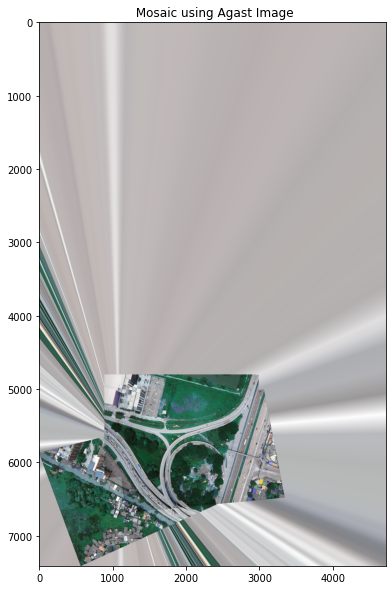

In [27]:
plt.figure(figsize=(20,10))
plt.imshow(warp_imgs_all_agast)
plt.title(' Mosaic using Agast Image')

In [32]:
omax,omin,umax,umin,T,H,W,HT = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_kaze,H_right_kaze)

Step1:Done
Step2:Done


In [33]:
warp_img = final_steps_left_union(images_left_bgr_no_enhance,H_left_kaze,omax,omin,umax,umin,T,H,W,HT)

step31:Done


In [35]:
warp_imgs_all_kaze = final_step_right_union(warp_img,images_right_bgr_no_enhance,H_right_kaze,omax,omin,umax,umin,T,H,W,HT)

step32:Done


Text(0.5, 1.0, ' Mosaic using Kaze Image')

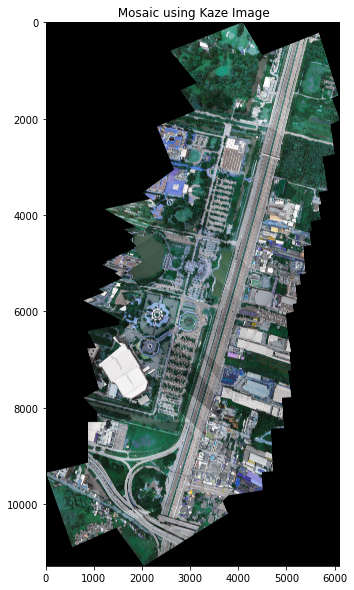

In [36]:
plt.figure(figsize=(20,10))
plt.imshow(warp_imgs_all_kaze)
plt.title(' Mosaic using Kaze Image')


In [23]:
mmax,mmin,nmax,nmin,d,e,f,g = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_sift,H_right_sift)

Step1:Done
Step2:Done


In [24]:
warp_imgs_sift = final_steps_left_union(images_left_bgr_no_enhance,H_left_sift,mmax,mmin,nmax,nmin,d,e,f,g)

step31:Done


In [25]:
warp_imgs_all_sift = final_step_right_union(warp_imgs_sift,images_right_bgr_no_enhance,H_right_sift,mmax,mmin,nmax,nmin,d,e,f,g)

step32:Done


Text(0.5, 1.0, ' Mosaic using Sift Image')

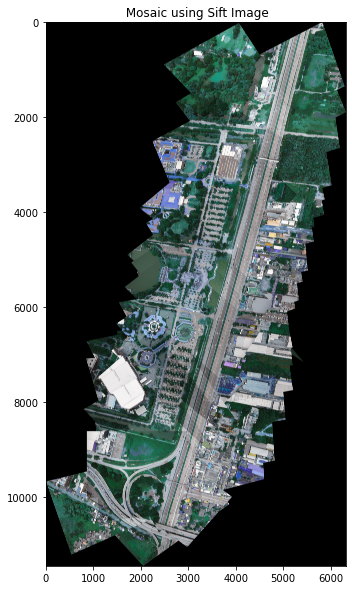

In [26]:
plt.figure(figsize=(20,10))
plt.imshow(warp_imgs_all_sift)
plt.title(' Mosaic using Sift Image')


In [30]:
omax,omin,umax,umin,T,H,W,HT = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_surf,H_right_surf)

Step1:Done
Step2:Done


In [31]:
warp_img_surf = final_steps_left_union(images_left_bgr_no_enhance,H_left_surf,omax,omin,umax,umin,T,H,W,HT)

step31:Done


In [32]:
warp_imgs_all_surf = final_step_right_union(warp_img_surf,images_right_bgr_no_enhance,H_right_surf,omax,omin,umax,umin,T,H,W,HT)

step32:Done


Text(0.5, 1.0, 'Mosaic using Surf Image')

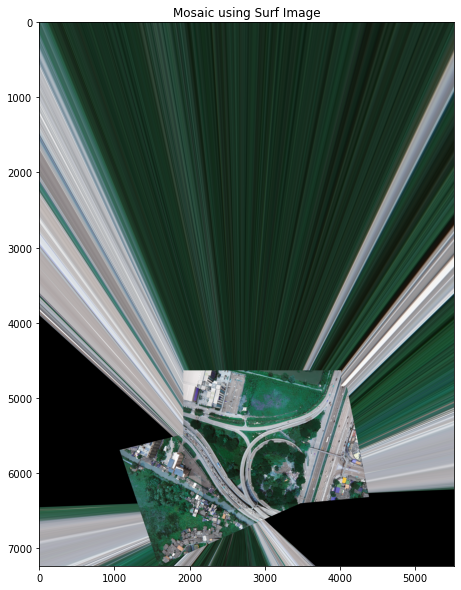

In [33]:
plt.figure(figsize=(20,10))
plt.imshow(warp_imgs_all_surf)
plt.title('Mosaic using Surf Image')


In [23]:
omax,omin,umax,umin,T,H,W,HT = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_akaze,H_right_akaze)


Step1:Done
Step2:Done


In [24]:
warp_img_akaze = final_steps_left_union(images_left_bgr_no_enhance,H_left_akaze,omax,omin,umax,umin,T,H,W,HT)

step31:Done


In [25]:
warp_imgs_all_akaze = final_step_right_union(warp_img_akaze,images_right_bgr_no_enhance,H_right_akaze,omax,omin,umax,umin,T,H,W,HT)

step32:Done


Text(0.5, 1.0, 'Mosaic using Akaze Image')

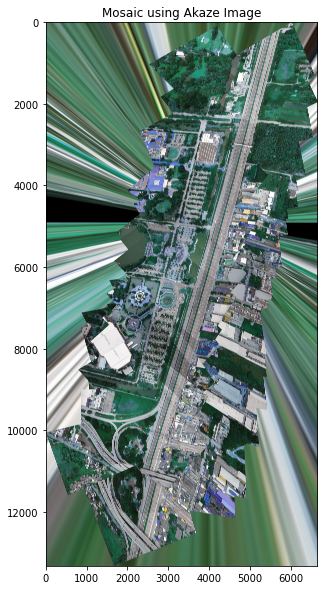

In [26]:
plt.figure(figsize=(20,10))
plt.imshow(warp_imgs_all_akaze)
plt.title('Mosaic using Akaze Image')


In [23]:
amax,amin,zmax,zmin,d,i,q,ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_daisy,H_right_daisy)

Step1:Done
Step2:Done


In [24]:
warp_image_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_daisy,amax,amin,zmax,zmin,d,i,q,ht)

step31:Done


In [25]:
warp_imgs_all_daisy = final_step_right_union(warp_image_left,images_right_bgr_no_enhance,H_right_daisy,amax,amin,zmax,zmin,d,i,q,ht)


step32:Done


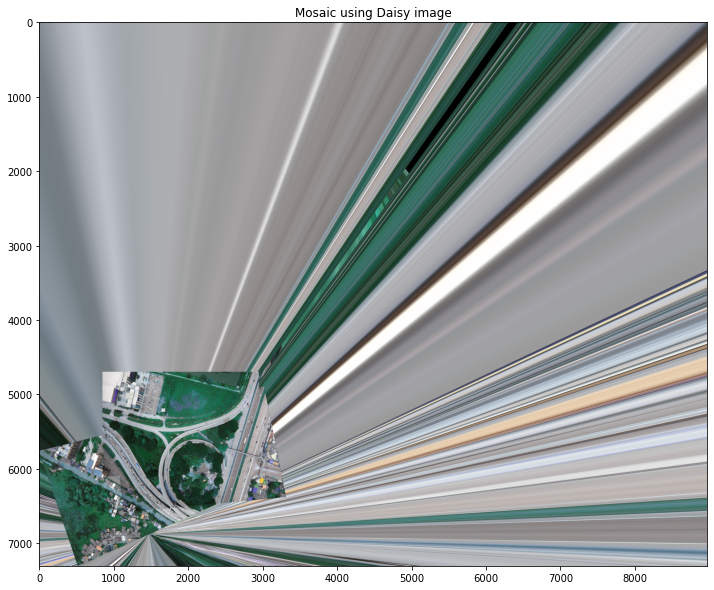

In [26]:
plt.figure(figsize=(20,10))
plt.imshow(warp_imgs_all_daisy)
plt.title('Mosaic using Daisy image')
plt.imsave('Mosaic using Daisy Image.jpg',warp_imgs_all_daisy)